# Quick description
Adapated from 25-03-29-daou-vs-dage-for-different-time-period-v1 so that the density thresholds for the water mass account for the entire density range (not only the significant trends)

# Import modules

In [1]:
%%time
%load_ext memory_profiler

#___________________________
# basics
import datetime
import os, glob, sys, gc
# import warnings
# warnings.filterwarnings('ignore', '.*invalid value encountered in true_divide.*', )

#___________________________
# To follow computations
from dask.diagnostics import ProgressBar
pbar = ProgressBar(minimum=10)
pbar.register()
#pbar.unregister()

#___________________________
# xarray numpy...
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
from fast_histogram import histogram2d
from scipy import stats

#___________________________
# To plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import cartopy.crs       as ccrs
import cartopy.feature as cfeature
import cartopy

import cmcrameri
import tol_colors

plt.figure()
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 150 # dpi for figure shonw in the notebook (ie. size of the figure)

#___________________________
# Extra
import pickle




CPU times: user 1.87 s, sys: 1.34 s, total: 3.21 s
Wall time: 3.3 s


<Figure size 432x288 with 0 Axes>

# Starters

In [12]:
%%time
%%memit -c
print(datetime.datetime.now())

dirout = '25-05-05-daou-vs-dage-for-different-time-period-v2/'
if not os.path.isdir(dirout) : os.mkdir(dirout)

dirshared = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/OceanICU/SHARED-DATAS/'

netcdfdir = dirout+'netcdf_files/'
if not os.path.isdir(netcdfdir) : os.mkdir(netcdfdir)

sys.stdout.echo = open(dirout+'stdout.txt', 'w')
sys.stderr.echo = open(dirout+'stderr.txt', 'w')

2025-05-05 16:47:27.480175
peak memory: 427.04 MiB, increment: 188.31 MiB
CPU times: user 99.4 ms, sys: 18.9 ms, total: 118 ms
Wall time: 226 ms


# Main parameters

In [4]:
%%time
%%memit -c

print(datetime.datetime.now())

cm2in = 1/2.54 # to convert from cm to inches

# Set custom font sizes
plt.rcParams['font.size'] = 8 # Default font size: 10.0
plt.rcParams['axes.titlesize'] = 8 # Default axes title font size: large
plt.rcParams['axes.labelsize'] = 6 # Default axes label font size: large
plt.rcParams['xtick.labelsize'] = 6 # Default tick labels font size: medium
plt.rcParams['ytick.labelsize'] = 6 # Default tick labels font size: medium
plt.rcParams['legend.fontsize'] = 6 # Default legend font size: medium
plt.rcParams['figure.titlesize'] = 10 # Default figure title font size: large

plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['ytick.major.width'] = .5
plt.rcParams['ytick.minor.width'] = .5

kwopends=dict(use_cftime=True, decode_times=None,
              decode_cf=True, decode_coords=True)
kwopenmfds = dict(combine='by_coords', parallel=True, 
                  use_cftime=True, decode_times=None,
                  decode_cf=True, decode_coords=True)

rename_dict = {
    "x": "i",
    "y": "j",
    "lat": "latitude", 
    "lon": "longitude",
    "nav_lat": "latitude", 
    "nav_lon": "longitude",
    'lev': 'depth', 
    'deptht': 'depth', 
    'olevel': 'depth', 
    "Depth":"depth"
}

# esm_color_dict = {
#     'MPI-ESM1-2-LR': tol_colors.tol_cset(colorset="bright").blue, 
#     'ACCESS-ESM1-5': tol_colors.tol_cset(colorset="bright").red,
#     'IPSL-CM6A-LR' : tol_colors.tol_cset(colorset="bright").green,
#     'MIROC-ES2L'   : tol_colors.tol_cset(colorset="bright").yellow,
#     'NorESM2-LM'   : tol_colors.tol_cset(colorset="bright").cyan
# }
esm_color_dict = {
    'MPI-ESM1-2-LR': cmcrameri.cm.batlowS.colors[0],
    'ACCESS-ESM1-5': cmcrameri.cm.batlowS.colors[1],
    'IPSL-CM6A-LR' : cmcrameri.cm.batlowS.colors[2],
    'MIROC-ES2L'   : cmcrameri.cm.batlowS.colors[3],
    'NorESM2-LM'   : cmcrameri.cm.batlowS.colors[4]
}

esm_name_dict = {
    'MPI-ESM1-2-LR': 'MPI-ESM1.2-LR',
    'ACCESS-ESM1-5': 'ACCESS-ESM1.5',
    'IPSL-CM6A-LR' : 'IPSL-CM6A-LR' ,
    'MIROC-ES2L'   : 'MIROC-ES2L'   ,
    'NorESM2-LM'   : 'NorESM2-LM'   , 
    'CanESM5'      : 'CanESM5'      , 
    'CNRM-ESM2-1'  : 'CNRM-ESM2-1'  ,
    'GFDL-ESM4'    : 'GFDL-ESM4'    ,
    'UKESM1-0-LL'  : 'UKESM1-0-LL'
}
picontrol_refyear_dict = {
    'MPI-ESM1-2-LR': 1850,
    'ACCESS-ESM1-5':  161,
    'IPSL-CM6A-LR' : 1910,
    'CanESM5'      : 5201,
    'MIROC-ES2L'   : 1850,
    'NorESM2-LM'   : 1600, 
    'CNRM-ESM2-1'  : 1850, 
    'GFDL-CM4'     :  101,
    'GFDL-ESM4'    :  101,
    'UKESM1-0-LL'  : 2250
}

#--------------------
# Dictionnaries for ESGF
#--------------------

variant_dict = {
    'MPI-ESM1-2-LR': 'r1i1p1f1',
    'ACCESS-ESM1-5': 'r1i1p1f1',
    'IPSL-CM6A-LR' : 'r1i1p1f1',
    'CanESM5'      : 'r1i1p1f1',
    'MIROC-ES2L'   : 'r1i1p1f2', 
    'CNRM-ESM2-1'  : 'r1i1p1f2', 
    'GFDL-CM4'     : 'r1i1p1f1',
    'GFDL-ESM4'    : 'r1i1p1f1',
    'UKESM1-0-LL'  : 'r1i1p1f2'
}

version_dict = {
    'piControl': {
        'thetao':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }, 
        'so':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }, 
        'o2':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }
    }, 
    'historical': {
        'thetao':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20180803',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20181206', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20190726',
            'UKESM1-0-LL'  : 'v20190627'
        }, 
        'so':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20180803',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20181206', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20190726',
            'UKESM1-0-LL'  : 'v20190627'
        }, 
        'o2':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20180803',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20181206', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20190726',
            'UKESM1-0-LL'  : 'v20190627'
        },
        'areacello':{
            'MPI-ESM1-2-LR': 'latest',
            'ACCESS-ESM1-5': 'latest',
            'IPSL-CM6A-LR' : 'latest',
            'CanESM5'      : 'latest',
            'MIROC-ES2L'   : 'latest',
            'CNRM-ESM2-1'  : 'latest', 
            'GFDL-CM4'     : 'latest',
            'GFDL-ESM4'    : 'latest',
            'UKESM1-0-LL'  : 'v20190705'
        }        

    }, 
    'ssp585': {
        'thetao':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }, 
        'so':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }, 
        'o2':{
            'MPI-ESM1-2-LR': 'v20190710',
            'ACCESS-ESM1-5': 'v20191115',
            'IPSL-CM6A-LR' : 'v20190903',
            'CanESM5'      : 'v20190429',
            'MIROC-ES2L'   : 'v20190823',
            'CNRM-ESM2-1'  : 'v20191021', 
            'GFDL-CM4'     : 'v20180701',
            'GFDL-ESM4'    : 'v20180701',
            'UKESM1-0-LL'  : 'v20190726'
        }
    }
}

grid_dict = {
    'thetao':{
        'MPI-ESM1-2-LR': 'gn',
        'ACCESS-ESM1-5': 'gn',
        'IPSL-CM6A-LR' : 'gn',
        'CanESM5'      : 'gn',
        'MIROC-ES2L'   : 'gn',
        'CNRM-ESM2-1'  : 'gn', 
        'GFDL-CM4'     : 'gr',
        'GFDL-ESM4'    : 'gr',
        'UKESM1-0-LL'  : 'gn'
    }, 
    'so':{
        'MPI-ESM1-2-LR': 'gn',
        'ACCESS-ESM1-5': 'gn',
        'IPSL-CM6A-LR' : 'gn',
        'CanESM5'      : 'gn',
        'MIROC-ES2L'   : 'gn',
        'CNRM-ESM2-1'  : 'gn', 
        'GFDL-CM4'     : 'gr',
        'GFDL-ESM4'    : 'gr',
        'UKESM1-0-LL'  : 'gn'
    }, 
    'o2':{
        'MPI-ESM1-2-LR': 'gn',
        'ACCESS-ESM1-5': 'gn',
        'IPSL-CM6A-LR' : 'gn',
        'CanESM5'      : 'gn',
        'MIROC-ES2L'   : 'gn',
        'CNRM-ESM2-1'  : 'gn', 
        'GFDL-CM4'     : 'gr',
        'GFDL-ESM4'    : 'gr',
        'UKESM1-0-LL'  : 'gn'
    }, 
    'areacello':{
        'MPI-ESM1-2-LR': 'gn',
        'ACCESS-ESM1-5': 'gn',
        'IPSL-CM6A-LR' : 'gn',
        'CanESM5'      : 'gn',
        'MIROC-ES2L'   : 'gn',
        'CNRM-ESM2-1'  : 'gn', 
        'GFDL-CM4'     : 'gr',
        'GFDL-ESM4'    : 'gr',
        'UKESM1-0-LL'  : 'gn'
    }
} 



2025-05-05 16:46:43.925449
peak memory: 381.20 MiB, increment: 165.47 MiB
CPU times: user 78.3 ms, sys: 19.9 ms, total: 98.1 ms
Wall time: 205 ms


# Define some functions

## Preparation of data 

In [5]:
def shift_180_lon(zwda, verbose=False): 
    if verbose: print("func: shift_180_lon")
    
    try: 
        if not np.nanmin(zwda['longitude']) < -150: 
            zwda['longitude'] = (zwda['longitude'] + 180) % 360 - 180
            addtxt=str(datetime.datetime.now())+' shift_180_lon to get longitude from -180 to 180'
            try: zwda.attrs['history'] =  addtxt + ' ; '+zwda.attrs['history']
            except: zwda.attrs['history'] =  addtxt             
        #
    except: print('WARNING! longitude likely not shifted')
    return zwda
#

def rename_vars_dims_coords(ds, rename_dict, verbose=False):
    """
    Renames variables, dimensions, and coordinates in an xarray Dataset according to the provided rename dictionary.

    Parameters:
    -----------
    ds : xr.Dataset
        The xarray Dataset to be renamed.
    rename_dict : Dict[str, str]
        Dictionary containing the variable, dimension, or coordinate names to be renamed. 
        The keys represent the original names, and the values represent the new names.
    verbose : bool, optional
        If True, prints the function name at the start and end of execution (default is False).
    
    Returns:
    --------
    xr.Dataset
        A new xarray Dataset with variables, dimensions, and coordinates renamed according to the rename dictionary.
    
    Example:
    --------
    import xarray as xr
    data = {'temp': ([], [0]), 'sali': ([], [1])}
    coords = {'time': [0]}
    ds = xr.Dataset(data, coords)
    renamed_ds = rename_vars_dims_coords(ds, {'temp': 'temperature', 'sali': 'salinity'})

    Dependencies:
    -------------
    xarray
    """
    if verbose: print('func: rename_vars_dims_coords')
    for old_name, new_name in rename_dict.items():
        if (old_name in ds.variables) | (old_name in ds.dims) | (old_name in ds.coords): 
            ds = ds.rename({old_name: new_name})
        #
    if verbose: print('endfunc')
    return ds
#

def split_coords_dimensions(ds, verbose=False):
    """
    Splits the latitude, longitude, and depth dimensions and coordinates of an xarray dataset into separate variables,
    updates their names, and assigns them back to the dataset.

    Parameters:
    -----------
    ds : xr.Dataset
        The xarray Dataset to be updated.
    verbose : bool, optional
        If True, prints the function name at the start and end of execution (default is False).
    
    Returns:
    --------
    xr.Dataset
        A new xarray Dataset with the latitude, longitude, and depth dimensions and coordinates split into separate variables
        and reassigned to the original dataset.
    
    Example:
    --------
    import xarray as xr
    data = {'temp': ([0, 1, 2], [0, 1]), 'sali': ([0, 1, 2], [0, 1])}
    coords = {'latitude': [0, 1, 2], 'longitude': [0, 1], 'depth': [0, 1, 2]}
    ds = xr.Dataset(data, coords)
    updated_ds = split_coords_dimensions(ds)

    Dependencies:
    -------------
    xarray
    """
    if verbose: print('func: split_coords_dimensions')
    new_coords = {}
    new_coords2 = {}
    new_dims = {}
    dim_name_dict = dict(latitude='j', longitude='i', depth='k')
    dimschanged = []
    for name, coord in ds.coords.items():
        if name in ds.dims and name in ["latitude", "longitude", "depth"]:
            new_coords[name + "_coord"] = coord
            new_dims[name] = dim_name_dict[name]
            new_coords2[name + "_coord"] = name
            dimschanged.append(name)
    if verbose: print('endfunc')
    for name in ['k', 'j', 'i']: 
        if name in ds.coords: dimschanged.append(name)
    #
    return ds.assign_coords(new_coords).rename_dims(new_dims).drop_vars(dimschanged).rename(new_coords2)
#


## Others

In [6]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
        nb: y[~nans] values of y that are not nans
            x(~nans) indexes of y that are not nans
    """

    return np.isnan(y), lambda z: z.nonzero()[0]
#

def get_esgf_dataset_filepaths(variable, sourceID, experimentID, 
                               freq='mon', grid='g*', version='latest', 
                               variant='r1i1p1f1',
                               mipera = 'CMIP6', diresgf='/mnt/reef-ns1002k-esgf/', verbose=False, **kwargs): 
    """
    Returns the filepaths of the remote netCDF files corresponding to the specified dataset of the Earth System
    Grid Federation (ESGF) data portal on NIRD.

    Parameters:
    -----------
    variable : str
        Variable to search for on ESGF data portal.
    sourceID : str
        Name of the data source on the ESGF data portal.
    experimentID : str
        Name of the experiment on the ESGF data portal.
    freq : str, optional
        Frequency of the data (default is 'mon').
    grid : str, optional
        Type of grid (default is 'g*').
    version : str, optional
        Version of the data being queried (default is 'latest').
    variant : str, optional
        Label for the variant of the data being queried (default is 'r1i1p1f1').
    mipera : str, optional
        Name of the CMIP era being queried (default is 'CMIP6').
    diresgf : str, optional
        Absolute path to the directory where the data is stored (default is '/mnt/reef-ns1002k-esgf/').
    verbose : bool, optional
        If True, prints the function name at the start and end of execution (default is False).
    **kwargs : dict, optional
        Other key-value arguments to be passed in the function.

    Returns:
    --------
    List[str]
        A list of filepaths corresponding to the specified dataset on the ESGF data portal.

    Example:
    --------
    fp_list = get_esgf_dataset_filepaths('tas', 'CanESM5', 'historical', freq='mon')

    Dependencies:
    -------------
    glob, sys
    """
    import glob, sys
    
    if verbose: print('func: get_esgf_dataset_filepaths')
    
    if experimentID in ['1pctCO2', 'piControl', 'historical', 'abrupt-4xCO2']: zwActivity='CMIP'
    elif experimentID in ['ssp126', 'ssp245', 'ssp585']: zwActivity='ScenarioMIP'
    else: sys.exit('Check experimentID, case not implemented')
    
    if sourceID in ['CESM2', 'CESM2-WACCM']: zwInstitutionID = 'NCAR'
    elif sourceID in ['ACCESS-ESM1-5']: zwInstitutionID = 'CSIRO'
    elif sourceID in ['CNRM-ESM2-1']: zwInstitutionID = 'CNRM-CERFACS'
    elif sourceID in ['CanESM5', 'CanESM5-CanOE']: zwInstitutionID = 'CCCma'
    elif sourceID in ['UKESM1-0-LL']: zwInstitutionID = 'MOHC'
    elif sourceID in ['GFDL-CM4', 'GFDL-ESM4']: zwInstitutionID = 'NOAA-GFDL'
    elif sourceID in ['IPSL-CM6A-LR', 'IPSL-CM6A-LR-INCA']: zwInstitutionID = 'IPSL'
    elif sourceID in ['MIROC-ES2L']: zwInstitutionID = 'MIROC'
    elif sourceID in ['MPI-ESM1-2-LR', 'ICON-ESM-LR']: zwInstitutionID = 'MPI-M'
    elif sourceID in ['NorESM2-LM']: zwInstitutionID = 'NCC'
    else: sys.exit('Check sourceID, case not implemented')
    
    ocean_list = ['fgco2', 'intpp', 'o2', 'thetao', 'so', 'agessc', 'po4', 'no3']
    if variable in ocean_list: zwTableID = 'O'+freq
    elif variable in ['areacello']: zwTableID='Ofx'
    elif variable in ['psl']: zwTableID='A'+freq
    else: sys.exit('!!! WARNING !!! Check variable, case not implemented')
        
    zwdname = diresgf + mipera +'/'+ zwActivity +'/'+ \
        zwInstitutionID +'/'+ sourceID +'/'+ \
        experimentID  +'/'+ variant +'/'+ zwTableID +'/'+ \
        variable+'/'+ grid +'/'+ version +'/'
    zwfname = variable +'_'+ zwTableID +'_'+ sourceID +'_'+ \
        experimentID +'_'+ variant +'_'+ grid +'*.nc' 

    if verbose: print('endfunc')
    return glob.glob(zwdname + zwfname)
#



## Spatial operations

In [7]:
def expand_coords(zwda, coord_name):
    """
    Expand the specified coordinate dimension to match the shape of zwda.

    Args
    ----
    zwda : xarray.DataArray
        The DataArray to extract and expand the coordinate from.
    coord_name : str
        The name of the coordinate to be expanded.

    Returns
    -------
    xarray.DataArray
        The expanded coordinate dimension.

    Examples
    --------
    dep_expanded = expand_coords(my_dataarray, 'depth')
    """
    import numpy as np
    shape = zwda.shape
    zwcoord = zwda[coord_name]
    common_dims = tuple(set(zwcoord.dims) & set(zwda.dims)) # get the common dimensions between the coordinate and zwda
    diff_dims = tuple(set(zwcoord.dims) ^ set(zwda.dims)) # get the different dimensions between the coordinate and zwda
    axis_to_expand = zwda.get_axis_num(diff_dims)
    len_of_axis_to_expand = np.ones_like(shape)
    for aaa in axis_to_expand: len_of_axis_to_expand[aaa]=shape[aaa]
    len_of_axis_to_expand = tuple(len_of_axis_to_expand)
    zw2 = np.tile(np.expand_dims(zwda[coord_name], axis=axis_to_expand), len_of_axis_to_expand)
    output = xr.zeros_like(zwda)
    output.values = zw2
    output.attrs = zwda[coord_name].attrs
    output.name = coord_name
    return output
#

def regrid(zwds, method='bilinear', dlon=1, dlat=1, verbose=False): 
    """
    Regrids the input Dataset to a grid with the specified longitude and latitude intervals using conservative regridding.

    Parameters:
    -----------
    zwds : xr.Dataset
        Dataset containing the data to regrid. Note that the Dataset must have the `zwds.cf.get_bounds` attribute.
    method : str
        Regridding method. Options are
        - 'bilinear' (default, recommended)
        - 'conservative', **need grid corner information** (recommended)
        - 'conservative_normed', **need grid corner information**
        - 'patch'
        - 'nearest_s2d'
        - 'nearest_d2s'
    dlon : float (default=1)
        Longitude interval in degrees for the output grid.
    dlat : float (default=1)
        Latitude interval in degrees for the output grid.

    Returns:
    --------
    xr.Dataset
        Regridded Dataset.

    Example:
    --------
    # Regrid a Dataset to a 1x1 degree grid
    regridded_data = regrid(zwds, dlon=1, dlat=1)

    Dependencies:
    -------------
    xesmf
    """
    if verbose: print('func: regrid')
    import xesmf as xe
    
    ds_in  = zwds.rename({'longitude':'lon', 'latitude':'lat', 'j':'y', 'i':'x'})

    zlat = ds_in.lat.values
    zlon = ds_in.lon.values
    zlatb, zlonb = compute_horizontal_bounds(zlon=zlon, zlat=zlat)
    zlatbda = xr.DataArray(data=zlatb, 
                          name='lat_b', 
                          dims=['y_b', 'x_b'],
                          coords=dict(
                              lon_b=(["y_b", "x_b"], zlonb), 
                              lat_b=(["y_b", "x_b"], zlatb)
                          ), 
                          attrs=dict(description="grid latitudnal bounds",units="degN")
                         )
    zlonbda = xr.DataArray(data=zlonb, 
                          name='lon_b', 
                          dims=['y_b', 'x_b'],
                          coords=dict(
                              lon_b=(["y_b", "x_b"], zlonb), 
                              lat_b=(["y_b", "x_b"], zlatb)
                          ), 
                          attrs=dict(description="grid longitudinal bounds",units="degN")
                         )
    ds_in = ds_in.assign_coords({'lon_b':zlonbda, 'lat_b':zlatbda})

    ds_out = xe.util.grid_global(dlon, dlat) # Here I define the output grid, in that case I want a regular 1 by 1 degree
    regridder = xe.Regridder(ds_in, ds_out, method, ignore_degenerate=True, unmapped_to_nan=True) # this the line if I do not have the weight alread
    zwds_regrided = regridder(ds_in).rename({'lon':'longitude', 'lat':'latitude', 'x':'i', 'y':'j'})
    ds_in = ds_in.rename({'lon':'longitude', 'lat':'latitude', 'x':'i', 'y':'j'})
    for kkk in zwds_regrided.variables.keys(): zwds_regrided.variables[kkk].attrs = ds_in.variables[kkk].attrs
    return zwds_regrided
#

def compute_horizontal_bounds(zlon=None, zlat=None, verbose=False): 
    """
    Returns the bounds of the grid from 2 numpy arrays giving the latitude and longitude 
    of the point in the middle of the grid-cells.

    Parameters:
    -----------
    zlon : np.ndarray
        Array of longitudes.
    zlat : np.ndarray
        Array of latitudes.

    Returns:
    --------
    Tuple of two numpy arrays: latitude bounds and longitude bounds.
    
    Example:
    --------
    # Compute horizontal bounds for a grid
    lat_b, lon_b = compute_horizontal_bounds(zlon, zlat)

    Dependecies:
    ------------
    numpy
    """
    import numpy as np
    if verbose: print('func: compute_horizontal_bounds')
    if (zlon.any()==None) | (zlat.any()==None): 
        exit('WARNING! no zlon or no zlat')
    #   

    zlatb  = 0.5*( np.roll(zlat, 1, axis=0) + zlat)
    zlatb[ 0, :] = zlat[0, :] - (zlatb[1, :] - zlat[0, :])
    zlatb1 = zlat[-1, :] + (zlat[-1, :] - zlatb[-1, :])
    zlatb = np.concatenate([zlatb, zlatb1[np.newaxis, :]], axis=0)
    zlatb = np.concatenate([zlatb, zlatb[:, -1][:, np.newaxis]], axis=1)
    
    zlonb  = 0.5*( np.roll(zlon, 1, axis=1) + zlon)
    zlonb[:, 0] = zlon[:, 0] - (zlonb[:, 1] - zlon[:, 0])
    zlonb1 = zlon[:, -1] + (zlon[:, -1] - zlonb[:, -1])
    zlonb = np.concatenate([zlonb, zlonb1[:, np.newaxis]], axis=1)
    zlonb = np.concatenate([zlonb, zlonb[-1, :][np.newaxis, :]], axis=0)

    return zlatb, zlonb
#

def vertical_interpolation(zwda, newdep, dimensions='zyx', verbose=False): 
    from scipy.interpolate import interp1d
    if verbose: print('func: vertical_interpolation')
    
    depaxis = zwda.get_axis_num('k')

    zwdep = zwda.depth
    # fff = interp1d(zwdep, zwda, axis=0, assume_sorted=True, fill_value='extrapolate')
    fff = interp1d(zwdep, zwda, axis=depaxis, assume_sorted=True, bounds_error=False, fill_value=float('nan'))
    # fff = interp1d(zwdep, zwda, axis=1, assume_sorted=True, fill_value='extrapolate')
    aaa = fff(newdep)
    if dimensions=='zyx': 
        output = xr.DataArray(data=aaa, 
                              coords={'depth':newdep, 
                                      'latitude':zwda.latitude, 
                                      'longitude':zwda.longitude}, 
                              dims=('k', 'j', 'i'), 
                              attrs=zwda.attrs, 
                              name=zwda.name)
    elif dimensions=='zy': 
        output = xr.DataArray(data=aaa, 
                              coords={'latitude':zwda.latitude, 
                                      'depth':newdep}, 
                              dims=('k', 'j'), 
                              attrs=zwda.attrs, 
                              name=zwda.name)
    #
    return output
#

def compute_vertical_average(zwda, zmin=None, zmax=None, verbose=False):
    """
    Computes the vertical average of a 3D or 4D xarray DataArray over a specified depth range.

    Parameters:
    -----------
    zwda : xr.DataArray
        3D or 4D DataArray to average.
    zmin : float
        Minimum depth in meters to average over. (Default is None)
    zmax : float
        Maximum depth in meters to average over. (Default is None)
    verbose : bool
        Print verbose output if True.

    Returns:
    --------
    xr.DataArray
        2D or 3D DataArray containing the vertical average of the input DataArray over the specified depth range.

    Example:
    --------
    avg_data = compute_vertical_average(data, zmin=0, zmax=100)

    Dependencies:
    -------------
    scipy.interpolate.interp1d
    """
    if verbose: print('func: compute_vertical_average')
    from scipy.interpolate import interp1d


    depaxis = zwda.get_axis_num('k')

    zwdep = zwda.depth
    zwdepbnds = 0.5 * (zwdep + zwdep.shift(k=1, fill_value=0))
    zwdepbnds[0] = 0
    zwDdep = zwdepbnds.shift(k=-1) - zwdepbnds
    zwDdep[-1] = 2 * (zwdep[-1] - zwdepbnds[-1])

    omask = ~(zwda.isnull())
    bathy = (omask * zwDdep).sum(dim='k')
    omaskH = ~(zwda.isnull().all(dim='k'))
    
    if (zmin is None) & (zmax is None): 
        zw2 = (zwda*zwDdep).sum(axis=depaxis)
        output = xr.where(omaskH, zw2/bathy, np.nan)
    elif (not zmin is None) & (zmax is None): 
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        zw2 = (zwda*zwDdep).sum(axis=depaxis) - fff(zmin)
        zmin3D = zmin+bathy*0
        waterthick = xr.where(zmin3D <= bathy, bathy - zmin3D, np.nan)
        output = xr.where(omaskH, zw2/waterthick, np.nan)
    elif (zmin is None) & (not zmax is None):
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        zw2 = fff(zmax)
        zmax3D = zmax+bathy*0
        waterthick = xr.where(zmax3D <= bathy, zmax3D, bathy)
        output = xr.where(omaskH, zw2/waterthick, np.nan)
    else:       
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        zw2 = fff(zmax) - fff(zmin)
        zmax3D = zmax+bathy*0
        zmin3D = zmin+bathy*0
        waterthick = np.nan + bathy*0
        waterthick = xr.where((zmin3D<=bathy) & (zmax3D<=bathy), zmax3D - zmin3D, waterthick)
        waterthick = xr.where((zmin3D<=bathy) & (zmax3D>bathy) , bathy  - zmin3D, waterthick)
        output = xr.where(omaskH, zw2/waterthick, np.nan)
    #
    
    output.attrs=zwda.attrs
    return output
#

def compute_vertical_sum(zwda, zmin=None, zmax=None, verbose=False):
    """
    Computes the vertical average of a 3D or 4D xarray DataArray over a specified depth range.

    Parameters:
    -----------
    zwda : xr.DataArray
        3D or 4D DataArray to average.
    zmin : float
        Minimum depth in meters to sum over. (Default is None)
    zmax : float
        Maximum depth in meters to sum over. (Default is None)
    verbose : bool
        Print verbose output if True.

    Returns:
    --------
    xr.DataArray
        2D or 3D DataArray containing the vertical average of the input DataArray over the specified depth range.

    Example:
    --------
    avg_data = compute_vertical_average(data, zmin=0, zmax=100)

    Dependencies:
    -------------
    scipy.interpolate.interp1d
    """
    if verbose: print('func: compute_vertical_average')
    from scipy.interpolate import interp1d
    
    depaxis = zwda.get_axis_num('k')
    
    zwdep = zwda.depth
    zwdepbnds = 0.5*(zwdep + zwdep.shift(k=1, fill_value=0))
    zwdepbnds[0] = 0
    zwDdep = zwdepbnds.shift(k=-1) - zwdepbnds
    zwDdep[-1] = 2*(zwdep[-1] - zwdepbnds[-1])

    if 'year' in zwda.dims: mask = zwda.isel(year=0, drop=True).isnull().all(dim='k')
    else: mask = zwda.isnull().all(dim='k')

    if (zmin is None) & (zmax is None): 
        output = xr.where(mask==1, np.nan, (zwda*zwDdep).sum(axis=depaxis))
    elif (not zmin is None) & (zmax is None): 
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        output = xr.DataArray((zwda*zwDdep).sum(axis=depaxis) - fff(zmin), 
                              coords=zwda.isel(k=0, drop=True).coords,
                              dims=zwda.isel(k=0, drop=True).dims,
                              attrs=zwda.isel(k=0, drop=True).attrs)
        output = output.where(mask==0)
    elif (zmin is None) & (not zmax is None):
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        output = xr.DataArray(fff(zmax), 
                              coords=zwda.isel(k=0, drop=True).coords,
                              dims=zwda.isel(k=0, drop=True).dims,
                              attrs=zwda.isel(k=0, drop=True).attrs)
        output = output.where(mask==0)
    else:       
        zw = (zwda*zwDdep).cumsum(axis=depaxis)
        fff = interp1d(zwDdep.cumsum(), zw, axis=depaxis, bounds_error=False)
        output = xr.DataArray(fff(zmax) - fff(zmin), 
                              coords=zwda.isel(k=0, drop=True).coords,
                              dims=zwda.isel(k=0, drop=True).dims,
                              attrs=zwda.isel(k=0, drop=True).attrs)
        output = output.where(mask==0)
    #
    output.attrs=zwda.attrs
    return output
#

def zonal_avg(zwda, weights, longitudes=None, return_3Dselection=False, verbose=False): 
    """
    Compute weithed zonal average between lonmin and lonmax
    Inputs: 
        - zwda: xarray DataArray
        - weights: xarray DataArray used for weighting zonal average
        - lonmin, lonmax: floats defining longitude for avereging
        - return_3Dselection: boolean to return or not the data selected for averaging. Default is False
        - verbose: boolean controlling prints in the code
    Ouput: 
        xarray DataArray with zonal average. 
        If return_3Dselection=True, then data selected for zonal averagin are also returned
    """
    
    from scipy.interpolate import interp1d
    
    if verbose: print('func: zonal_avg')
    
    if 'k' in weights.dims: weight_for_zlat = weights.isel(k=0, drop=True)
    else: weight_for_zlat = weights
    
    if longitudes==None: 
        # compute zonal average weighted
        with xr.set_options(keep_attrs=True): 
            output = zwda.weighted(weights.fillna(0)).mean(dim='i', skipna=True)
            zwlat  = zwda['latitude'].weighted(weight_for_zlat.fillna(0)).mean(dim='i', skipna=True)
        #
    else: 
        # Select longitudes
        LONSEL = (zwda.longitude<=longitudes[1]) & (zwda.longitude>=longitudes[0])
        zw  = (zwda.T).where(LONSEL.T, np.nan).T
        zw2 = (zwda['latitude'].T).where(LONSEL.T, np.nan).T
        # compute zonal average weighted
        with xr.set_options(keep_attrs=True): 
            output = zw.weighted(weights.fillna(0)).mean(dim='i', skipna=True)
            zwlat  = zw2.weighted(weight_for_zlat.fillna(0)).mean(dim='i', skipna=True)
        #
    #
    
    #______________
    # Adjust latitude zonally average
    if zwlat.isnull().any(): # if there is nan values in zwlat, replace by the mean non weighted
        if longitudes==None: 
            zwlat = xr.where(zwlat.isnull(), 
                             zwda['latitude'].mean(dim='i', skipna=True),
                             zwlat)
        else: 
            zwlat = xr.where(zwlat.isnull(), 
                             xr.where( LONSEL.T, zwda['latitude'].T, np.nan).T.mean(dim='i', skipna=True), 
                             zwlat)
        #
    #
    if zwlat.isnull().any(): # if there is nan values in zwlat_iavg, replace by extrapolation
        aaa = zwlat.values
        t1 = np.arange(len(aaa))
        bbb = aaa[~np.isnan(aaa)]
        t2 = t1[~np.isnan(aaa)]
        f = interp1d(t2, bbb, fill_value='extrapolate')
        zwlat[np.isnan(aaa)] = f(t1[np.isnan(aaa)])
    #
        
    #______________
    # Set new latitude coordinates
    with xr.set_options(keep_attrs=True): output = output.assign_coords({'latitude':zwlat})
    if (return_3Dselection) & (longitudes!=None): 
        return output, zw
    else: return output
#

def gridArea(zlon=None, zlat=None, rd=6371000.00, verbose=False):
    """
    Compute grid_area from longitude and latitude
    Inputs: 
        - zlon: 2D numpy Array with longitude. If None (default) zlon 
        and zlat are 1deg grid
        - zlat: same as zlon but with latitude
        - rd: float with Earth radius: 6371000.00m (default)
    Output: xarray DataArray with grid cell area
    """
    # adapted from Jean Negrel: 
    # for n in range(len(lat)):
    #     for m in range(len(lon)):
    #         rlat1 = np.deg2rad(lat[n]+0.5)
    #         rlat2 = np.deg2rad(lat[n]-0.5)
    #         rlon1 = np.deg2rad(lon[m]+0.5)
    #         rlon2 = (np.deg2rad(lon[m]-0.5))
    #         drlon = rlon1 - rlon2
    #         if abs(drlon) >= (2*np.pi - abs(drlon)) :
    #             drlon = drlon+2*np.pi
    #         grid[n,m] = drlon*abs( np.sin(rlat2) - np.sin(rlat1) )
    # #print(grid.sum()-4*np.pi) # Must be as close as possible to 0
    # grid  = grid*rd*rd
    # grid = xr.DataArray(grid, coords=[lat, lon], dims=['lat', 'lon'])
    # #print(grid.sum()) # Actual Earth area: 510,065,623 km2 (source: Wikipedia)

    if verbose: print('func: gridArea')
    
    if (zlon.any()==None) | (zlat.any()==None): 
        zlon, zlat = np.meshgrid(np.arange(-179.5, 180, 1), np.arange(-89.5, 90, 1))
    #   
    
    zlat1        = 0.5*( np.roll(zlat, -1, axis=0) + zlat)
    zlat1[-1, :] = zlat[-1, :] + (zlat[-1, :] - zlat1[-2, :])
    zlat2        = 0.5*( np.roll(zlat, 1, axis=0) + zlat)
    zlat2[ 0, :] = zlat[0, :] - (zlat2[1, :] - zlat[0, :])

    zlon1        = 0.5*( np.roll(zlon, -1, axis=1) + zlon)
    zlon1[:, -1] = zlon[:, -1] + (zlon[:, -1] - zlon1[:, -2])
    zlon2        = 0.5*( np.roll(zlon, 1, axis=1) + zlon)
    zlon2[:,  0] = zlon[:, 0] - (zlon2[:, 1] - zlon[:, 0])

    zlat1_rad = np.deg2rad(zlat1)
    zlat2_rad = np.deg2rad(zlat2)
    zlon1_rad = np.deg2rad(zlon1)
    zlon2_rad = np.deg2rad(zlon2)
    
    dlon_rad = zlon1_rad - zlon2_rad
    dlon_rad = np.where( (abs(dlon_rad) >= (2*np.pi - abs(dlon_rad))), \
                        dlon_rad+2*np.pi, dlon_rad) 
    
    grid_area = rd*rd*dlon_rad*abs( np.sin(zlat2_rad) - np.sin(zlat1_rad) )
    output = xr.DataArray(data=grid_area, 
                          name='area', 
                          dims=['j', 'i'],
                          coords=dict(
                              longitude=(["j", "i"], zlon), 
                              latitude=(["j", "i"], zlat)
                          ), 
                          attrs=dict(description="Grid area",units="m2")
                         )
    if verbose: print(f"    Total grid area is {output.sum().values*1e-6:.1f}km2\
    \n    i.e. {output.sum()*1e-6/510065623*100:.1f}% of the actual Earth area (510065623km2 source: Wikipedia)\
    \n    Total grid area is {output.sum()*1e-6 - 510065623:.1f}km2 of the actual Earth area") 
    # if verbose: print("Total grid area is %.1f %% of actual Earth area: \
    # 510,065,623 km2 (source: Wikipedia)" %output.sum()*1e-6/510065623*100) 

    return output
#

def compute_vertical_bounds_thickness(zwdep1D): 
    """
    Compute vertical bounds and thicknesses 1D depth array.

    This function takes a one-dimensional series of depth values and computes
    the vertical boundaries and thicknesses for each layer.

    Parameters
    ----------
    zwdep1D : array-like
        One-dimensional array or series of depth values.

    Returns
    -------
    zwdepbnds1D : array-like
        One-dimensional array representing the vertical bounds for each layer.

    zwDdep1D : array-like
        One-dimensional array representing the thicknesses of each layer.

    Notes
    -----
    - The input is assumed to have a `shift` method, similar to a pandas Series.
    - The first vertical boundary is set explicitly to zero (surface level).
    - The thickness of the last layer is adjusted to ensure accurate representation.
    
    Example
    -------
    >>> import pandas as pd
    >>> depths = pd.Series([10, 20, 30, 40])
    >>> bounds, thicknesses = compute_vertical_bounds_(depths)
    >>> print(bounds)
    0     0.0
    1     5.0
    2    15.0
    3    25.0
    dtype: float64
    >>> print(thicknesses)
    0     5.0
    1    10.0
    2    10.0
    3    10.0
    dtype: float64
    """
    zwdepbnds1D = 0.5 * (zwdep1D + zwdep1D.shift(k=1, fill_value=0))
    zwdepbnds1D[0] = 0
    zwDdep1D = zwdepbnds1D.shift(k=-1) - zwdepbnds1D
    zwDdep1D[-1] = 2 * (zwdep1D[-1] - zwdepbnds1D[-1])
    return zwdepbnds1D, zwDdep1D
#    


## Mapping functions

In [8]:
def adjust_vmin_vmax(data, q=0.1, round_up=True):
    """
    Computes vmin and vmax based on quantiles of the data and optionally
    rounds them up to values that make sense.
    
    Args:
    - data (ndarray): 2D array of data
    - q (float, optional): quantile used to compute vmin and vmax (default: 0.1)
    - round_up (bool, optional): whether to round up vmin and vmax to "nice" values (default: True)
    
    Returns:
    - tuple: vmin and vmax values
    """
    vmin = np.nanpercentile(data, q * 100)
    vmax = np.nanpercentile(data, (1 - q) * 100)
    
    if round_up:
        
        mag = 10 ** np.floor(np.log10(vmax - vmin))
        vmin1 = np.floor(vmin / mag)
        vmax1 = np.ceil(vmax / mag)
        nb_of_mag= np.round((vmax-vmin)/mag)
        icount = 0
        while (vmax1-vmin1)/nb_of_mag > 1.2: 
            dvmin = vmin-vmin1*mag
            dvmax = vmax1*mag - vmax
            if dvmax>dvmin: vmax1=np.round(vmax1-.1, 1)    
            else: vmin1=np.round(vmin1+.1, 1) 
        #
        vmax = vmax1*mag
        vmin = vmin1*mag
    #
    
    return vmin, vmax
#
def map_whole_globe(zwdataarray, zwax=None, bcolorbar=True, zwcbLabel='', zwcbExtend='both', verbose=False, **pcmkwargs): 
    """
    Plot a global map of the input DataArray 
    Inputs: 
        - zwax are GeoAxes created with cartopy
          e.g.:
            lonlatproj = ccrs.PlateCarree()
            ccrsproj = ccrs.Robinson(central_longitude=-155)
            fig = plt.figure(figsize = (10, 10))
            ax = plt.axes(projection=ccrsproj)
            pcmkwargs = dict(transform=lonlatproj)
            map_whole_globe(zwda, ax, **pcmkwargs)
          if None (default), theyr are created within the function
        - zwcbLabel: string to set label of colorbar. Default is ''
        - zwcbExtend: 'none', 'min', 'max' or 'both' (default)
        - **pcmkwargs are kwargs pass to matplotlib pcolormesh function
    Outputs: zwax the axes and  zwpcm the pcolormesh
    
    """
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.colors import ListedColormap

    import cartopy.crs       as ccrs
    
    if verbose: print('func: map_whole_globe')
    
    zwlonlatproj = ccrs.PlateCarree()
    
    try:
        pcmkwargs
    except NameError:
        pcmkwargs_exists = False
    else:
        pcmkwargs_exists = True
    #

    if pcmkwargs_exists: 
        original_pcmkwargs = pcmkwargs.copy()
        if not 'vmin' in pcmkwargs: pcmkwargs['vmin'] = zwdataarray.quantile(.1).values
        elif pcmkwargs['vmin'] is None: pcmkwargs['vmin'] = zwdataarray.quantile(.1).values
        if not 'vmax' in pcmkwargs: pcmkwargs['vmax'] = zwdataarray.quantile(.9).values
        elif pcmkwargs['vmax'] is None: pcmkwargs['vmax'] = zwdataarray.quantile(.9).values
        if not 'transform' in pcmkwargs: pcmkwargs['transform'] = zwlonlatproj
        if not 'cmap' in pcmkwargs: 
            if (pcmkwargs['vmin']*pcmkwargs['vmax']<0): a = cm.get_cmap('RdBu',64)
            else: a = cm.get_cmap('viridis',64)
            if zwcbExtend=='both': 
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors[1:-1])
                newcmap.set_over(colors[-1])
                newcmap.set_under(colors[0])
            elif zwcbExtend=='max': 
                colors = a(np.linspace(0,1,10+1))
                newcmap = ListedColormap(colors[:-1])
                newcmap.set_over(colors[-1])
                newcmap.set_under("none")
            elif zwcbExtend=='min': 
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors[1:])
                newcmap.set_over("none")
                newcmap.set_under(colors[0])
            else:
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors)
                newcmap.set_over("none")
                newcmap.set_under(colors[0])
            #
            newcmap.set_bad("none")
            pcmkwargs['cmap'] = newcmap
        #
    else:
        pcmkwargs['vmin'] = zwdataarray.quantile(.1).values
        pcmkwargs['vmax'] = zwdataarray.quantile(.9).values
        pcmkwargs={'transform':zwlonlatproj}
        if (pcmkwargs['vmin']*pcmkwargs['vmax']<0): a = cm.get_cmap('RdBu',64)
        else: a = cm.get_cmap('viridis',64)
        if zwcbExtend=='both': 
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors[1:-1])
            newcmap.set_over(colors[-1])
            newcmap.set_under(colors[0])
        elif zwcbExtend=='max': 
            colors = a(np.linspace(0,1,10+1))
            newcmap = ListedColormap(colors[:-1])
            newcmap.set_over(colors[-1])
            newcmap.set_under("none")
        elif zwcbExtend=='min': 
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors[1:])
            newcmap.set_over("none")
            newcmap.set_under(colors[0])
        else:
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors)
            newcmap.set_over("none")
            newcmap.set_under(colors[0])
        #
        newcmap.set_bad("none")
        pcmkwargs['cmap'] = newcmap
    #

    XXX = zwdataarray['longitude'].values
    YYY = zwdataarray['latitude'].values
    ZZZ = zwdataarray.values
    if not zwax is None: 
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
    else: 
        print("WARNING! zwax is None, create zwfig and zwax")
        zwccrsproj = ccrs.Robinson(central_longitude=-155)
        zwfig = plt.figure(figsize = (10, 10))
        zwax = plt.axes(projection=zwccrsproj)
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
    #
    zwax.set_global()
    add_gridlines_coastline_and_land(zwax)
    # zwax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m',edgecolor='none',facecolor='wheat'))
    # zwax.add_feature(cfeature.COASTLINE)
    # zwax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
    #                color='k', linestyle='dashed', linewidth=0.5)

    if bcolorbar: 
        zwcb = plt.colorbar(zwpcm, label=zwcbLabel, extend=zwcbExtend)
        zw = zwax.get_position()
        nx0 = zw.x1+.07*zw.width
        ny0 = zw.y0+.1*zw.height
        nhh = .8*zw.height
        nww = .1*nhh    
        zwcb.ax.set_position([nx0, ny0, nww, nhh])
        ttt=np.linspace(zwcb.vmin, zwcb.vmax, int(len(zwcb.cmap.colors)/2)+1)
        zwcb.ax.set_yticks(ttt)

    #___________
    # # restore the original kwargs before returning
    if pcmkwargs_exists:
        pcmkwargs.clear()
        pcmkwargs.update(original_pcmkwargs)
    #
    return zwax, zwpcm
#

def add_gridlines_coastline_and_land(zax, zxlocs=[-120, -60, 0, 60, 120, 180], \
                                     zylocs=[-60, -40, -20, 0, 20, 40, 60], \
                                     noticklabels=False, verbose=False): 

    import cartopy.feature as cfeature
    import matplotlib.ticker as mticker
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER, LatitudeFormatter, LongitudeFormatter
    
    if verbose: print('func: add_gridlines_coastline_and_land')
    
    # zax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m',edgecolor='none',facecolor='wheat'))
    zax.add_feature(cfeature.LAND, facecolor='wheat')
    zax.add_feature(cfeature.COASTLINE, linewidth=.5)
    
    if not noticklabels: gl = zax.gridlines(draw_labels=['left', 'right'], 
                                            x_inline=False, y_inline=False,
                                            xlocs = mticker.FixedLocator(zxlocs), 
                                            xlabel_style = {'size': 'small'}, 
                                            ylocs = mticker.FixedLocator(zylocs), 
                                            ylabel_style = {'size': 'small'}, dms=True,
                                            color='k', linestyle='dashed', linewidth=0.5, alpha=.5)
    else: gl = zax.gridlines(draw_labels=False, 
                             x_inline=False, y_inline=False,
                             xlocs = mticker.FixedLocator(zxlocs), 
                             ylocs = mticker.FixedLocator(zylocs), 
                             dms=True,
                             color='k', linestyle='dashed', linewidth=0.5, alpha=.5)
    # gl = zwax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
    #                     color='k', linestyle='dashed', linewidth=0.5)
    return gl
#

def map_orthographic(zwdataarray, zoombox=(0, 0), \
                     zwax=None, zwcbLabel='', zwcbExtend='both', **pcmkwargs): 
    """
    Plot the input DataArray 
    zoombox either indicate the center [clon, clat] of the Orthographic projection (list of 2) 
        or the bounds of the projection [lonmin, lonmax, latmin, latmax]. Default is (0, 0)
    zwax are GeoAxes created with cartopy
    e.g.:
        lonlatproj = ccrs.PlateCarree()
        ccrsproj = ccrs.Orthographic(central_longitude=-20, central_latitude=-25)
        fig = plt.figure(figsize = (10, 10))
        ax = plt.axes(projection=ccrsproj)
        pcmkwargs = dict(transform=lonlatproj)
        map_whole_globe(zwda, ax, **pcmkwargs)
    if zwax = None (default), they are created within the function
    """
    print('func: map_orthographic')
    
    try:
        pcmkwargs
    except NameError:
        pcmkwargs_exists = False
    else:
        pcmkwargs_exists = True
    #


    zwlonlatproj = ccrs.PlateCarree()
    if pcmkwargs_exists: 
        if not 'transform' in pcmkwargs: pcmkwargs['transform'] = zwlonlatproj
    else: pcmkwargs={'transform':zwlonlatproj}

    XXX = zwdataarray['longitude'].values
    YYY = zwdataarray['latitude'].values
    ZZZ = zwdataarray.values
    if not zwax is None: 
        print("WARNING! zwax is given, ignoring zoombox")
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
        zwax.set_global()
        zxlocs = list(np.arange(-150, 200, 30))
        add_gridlines_coastline_and_land(zwax, zxlocs=zxlocs)

    else: 
        print("WARNING! zwax is None, create zwfig and zwax")

        if len(zoombox)==4: 
            lonmin, lonmax, latmin, latmax = zoombox
            clon, clat = lonmin+.5*(lonmax-lonmin), latmin+.5*(latmax-latmin)
        elif len(zoombox)==2: clon, clat= zoombox
        else: sys.exit('ERROR! Check zoombox, it should be a list of length 2 or 4')

        zwccrsproj = ccrs.Orthographic(central_longitude=clon, central_latitude=clat)
        zwfig = plt.figure(figsize = (5, 5))
        zwax = plt.axes(projection=zwccrsproj)
        zwpcm = zwax.pcolormesh(XXX, YYY, ZZZ, **pcmkwargs)
        

        if len(zoombox)==4 : 
            xmin, _ = zwax.projection.transform_point(lonmin, clat, zwlonlatproj)  
            xmax, _ = zwax.projection.transform_point(lonmax, clat, zwlonlatproj)  
            _, ymin = zwax.projection.transform_point(clon, latmin, zwlonlatproj)  
            _, ymax = zwax.projection.transform_point(clon, latmax, zwlonlatproj) 
            zwax.set_extent([xmin,xmax,ymin,ymax], crs=zwax.projection)
            zxlocs = list(np.arange(lonmin, lonmax, np.round((50+60)/4, -1)))
            add_gridlines_coastline_and_land(zwax, zxlocs=zxlocs)
        elif len(zoombox)==2: 
            zwax.set_global()
            zxlocs = list(np.arange(-150, 200, 30))
            add_gridlines_coastline_and_land(zwax, zxlocs=zxlocs)
        #
    #

    zwcb = plt.colorbar(zwpcm, label=zwcbLabel, extend=zwcbExtend)
    zw = zwax.get_position()
    nx0 = zw.x1+.15*zw.width
    ny0 = zw.y0+.1*zw.height
    nhh = .8*zw.height
    nww = .1*nhh    
    zwcb.ax.set_position([nx0, ny0, nww, nhh])
    ttt=np.linspace(zwcb.vmin, zwcb.vmax, int(len(zwcb.cmap.colors)/2)+1)
    zwcb.ax.set_yticks(ttt)
    return zwax, zwpcm
#


def plot_section(dataarray, ax=None, bcolorbar=True, cbLabel='', cbExtend='both', title='Zonal average', plottype='pcolormesh', 
                 xlim=(-90, 90), xlabel='Deg. North', ylim=(5000, -10), ylabel='Depth [m]', inline=False, 
                 kwpcm={}, kwct={}, verbose=False):
    
    """
    Plot a vertical & meridional section
    Inputs: 
        - dataarray: 2D xarray DataArray to plot
        - ax: a set of matplolib axes (e.g. plt.axes), if None (default) axes are created
        - cbLabel: a string for labelling the colorbar. Default is ''
        - cbExtend: 'none', 'min', 'max' or 'both' (default)
        - title: string to give title to the plot. Default is 'Zonal average'
        - plottype: 'pcolormesh' (default) or 'contour' or 'both'. To define the type of plot.
        - xlim: tuple defining the x axis limits. Default is (-90, 90)
        - ylim: tuple defining the y axis limits. Default is (1000, -10)
        - xlabel: string for x axis label
        - ylabel: string for y axis label
        - inline: boolean to set contour labels. Default is False
        - kwpcm: kwargs to pass to pcolormesh
        - kwct: kwargs to pass to contour
    """
    
    #___________
    # Import
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    
    if verbose: print('func: plot_section')
    
    #___________
    # Do kwpcm exist?
    try:
        kwpcm
    except NameError:
        kwpcm_exists = False
    else:
        kwpcm_exists = True
    #

    #___________
    # set cmap, vmin and vmax if they are not define
    if kwpcm_exists: 
        original_kwpcm = kwpcm.copy()
        if not 'cmap' in kwpcm: 
            a = cm.get_cmap('viridis',64)
            if cbExtend=='both': 
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors[1:-1])
                newcmap.set_over(colors[-1])
                newcmap.set_under(colors[0])
            elif cbExtend=='max': 
                colors = a(np.linspace(0,1,10+1))
                newcmap = ListedColormap(colors[:-1])
                newcmap.set_over(colors[-1])
                newcmap.set_under("none")
            elif cbExtend=='min': 
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors[1:])
                newcmap.set_over("none")
                newcmap.set_under(colors[0])
            else:
                colors = a(np.linspace(0,1,10+2))
                newcmap = ListedColormap(colors)
                newcmap.set_over("none")
                newcmap.set_under(colors[0])
            #
            newcmap.set_bad("none")
            kwpcm['cmap'] = newcmap
        #
        if not 'vmin' in kwpcm: kwpcm['vmin'] = dataarray.quantile(.1).values
        if not 'vmax' in kwpcm: kwpcm['vmax'] = dataarray.quantile(.9).values
    elif (not kwpcm_exist) & (plottype in ['pcolormesh', 'both']):
        kwpcm = {}
        a = cm.get_cmap('viridis',64)
        if cbExtend=='both': 
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors[1:-1])
            newcmap.set_over(colors[-1])
            newcmap.set_under(colors[0])
        elif cbExtend=='max': 
            colors = a(np.linspace(0,1,10+1))
            newcmap = ListedColormap(colors[:-1])
            newcmap.set_over(colors[-1])
            newcmap.set_under("none")
        elif cbExtend=='min': 
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors[1:])
            newcmap.set_over("none")
            newcmap.set_under(colors[0])
        else:
            colors = a(np.linspace(0,1,10+2))
            newcmap = ListedColormap(colors)
            newcmap.set_over("none")
            newcmap.set_under(colors[0])
        #
        newcmap.set_bad("none")
        kwpcm['cmap'] = newcmap
        kwpcm['vmin'] = dataarray.quantile(.1).values
        kwpcm['vmax'] = dataarray.quantile(.9).values
    #

    #___________
    # Do kwct exist?
    try:
        kwct
    except NameError:
        kwct_exists = False
    else:
        kwct_exists = True
    #

    #___________
    # set colors for contour
    if kwct_exists: 
        original_kwct = kwct.copy()
        if not 'colors' in kwct: kwct['colors'] = 'red'
    elif (not kwct_exists) & (plottype in ['contour', 'both']):
        kwct = {'colors':'red'}
    #

    #___________
    # Create axes if needed
    if ax is None: 
        if verbose: print("WARNING! ax is None, create ax")
        ax = plt.axes()
    #
    
    #___________
    # Plot
    if plottype in ['pcolormesh', 'both']: zwpcm = ax.pcolormesh(dataarray.latitude, dataarray.depth, dataarray, **kwpcm)
    if plottype in ['contour', 'both']: 
        zwct = ax.contour(dataarray.latitude, dataarray.depth, dataarray, **kwct)
        ax.clabel(zwct, inline=inline)
    #
    #___________
    # Decorate plot
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xlim)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    
    
    #___________
    # Colorbar
    if bcolorbar: 
        try: 
            zwcb = plt.colorbar(zwpcm, label=cbLabel, extend=cbExtend)
            zw = ax.get_position()
            nx0 = zw.x1+.07*zw.width
            ny0 = zw.y0+.1*zw.height
            nhh = .8*zw.height
            nww = .1*nhh    
            zwcb.ax.set_position([nx0, ny0, nww, nhh])
            ttt=np.linspace(zwcb.vmin, zwcb.vmax, int(len(zwcb.cmap.colors)/2)+1)
            zwcb.ax.set_yticks(ttt)
        except: 
            if verbose: print('No colorbar')
        #
    #

    #___________
    # # restore the original kwargs before returning
    if kwpcm_exists:
        kwpcm.clear()
        kwpcm.update(original_kwpcm)
    #
    if kwct_exists:
        kwct.clear()
        kwct.update(original_kwct)
    #

    #___________
    # Return
    if ('zwpcm' in locals()) & ('zwct' in locals()): 
        return zwpcm, zwct
    elif ('zwpcm' in locals()): 
        return zwpcm
    elif ('zwct' in locals()): 
        return zwct
    else: 
        print('Nothing have been plot')
        return 
#



## Diagnostics

In [9]:
def compute_potential_density_anomaly( temp, sali ): 
    """
    Computes the potential density anomaly with reference pressure of 0 dbar given temperature and salinity arrays.

    Parameters:
    -----------
    temp : xarray.DataArray
        Array of temperature values. 
        Should have the following dimensions: latitude, longitude, and depth.
    sali : xarray.DataArray
        Array of salinity values.
        Should have the following dimensions: latitude, longitude, and depth.

    Returns:
    --------
    xarray.DataArray
        Array of potential density anomaly values with reference pressure of 0 dbar. 
        Has the same dimensions as `temp` and `sali`.
    
    Dependencies:
    -------------
    gsw_xarray
    """
    import gsw_xarray as gsw

    zwlat = temp['latitude']
    zwlon = temp['longitude']
    zwlev = temp['depth']

    # Compute sea pressure
    zwseapr = gsw.conversions.p_from_z(-zwlev, zwlat)

    # Compute absolute salinity
    zwSA = gsw.conversions.SA_from_SP(sali, zwseapr, zwlon, zwlat)

    # Compute conservative temperature
    zwCT = gsw.conversions.CT_from_pt(zwSA, temp)

    # Compute potential density anomaly
    zwsigma0 = gsw.density.sigma0(zwSA, zwCT)

    zwsigma0.attrs['comment']= 'Potential density anomaly with reference pressure of 0 dbar, this being this particular \
    potential density minus 1000 kg/m^3. This function has inputs of Absolute Salinity and Conservative Temperature. \
    This function uses the computationally-efficient expression for specific volume in terms of SA, CT and p (Roquet et al., 2015).'
    zwsigma0.attrs['long_name']='Potential density anomaly with reference pressure of 0 dbar'
    addtxt = str(datetime.datetime.now())+' '+'gsw.density.sigma0 to compute potential density anomaly with reference pressure of 0 dbar'
    try : zwsigma0.attrs['history'] = addtxt+' ; '+zwsigma0.attrs['history']
    except: zwsigma0.attrs['history']=addtxt
    
    return zwsigma0
#

def coloring_2D_bins(xxx, yyy, ccc, stat='mean', nbin=100, delta_bin=None): 
    """
    Compute the binned statistical summary of coloring values for 2D data arrays.

    This function flattens the 2D input arrays, removes nan values, and computes the
    specified statistical summary (by default, the mean) for the given bins in the
    two-dimensional space defined by `xxx` and `yyy`.

    Parameters
    ----------
    xxx : array-like
        2D array representing the x-coordinates of the data points.
    yyy : array-like
        2D array representing the y-coordinates of the data points.
    ccc : array-like
        2D array representing the coloring values corresponding to the data points.
    stat : str, optional
        The statistic to compute (default is 'mean'). Possible values are 'mean',
        'median', 'count', 'sum', 'std', etc., as supported by scipy.stats.binned_statistic_dd.
    nbin : int, optional
        Number of bins along each dimension (default is 100) if `delta_bin` is not provided.
    delta_bin : array-like, optional
        Array of length 2 specifying the bin width for each dimension. If provided,
        `nbin` is ignored, and the bins are computed based on the specified widths.

    Returns
    -------
    dict
        A dictionary with the following keys:
            'xxx': array
                The edges of the bins along the x-dimension.
            'yyy': array
                The edges of the bins along the y-dimension.
            'ccc': array
                The computed statistical summary for each bin, after transposing the result.

    Examples
    --------
    >>> import numpy as np
    >>> from scipy.stats import binned_statistic_dd
    >>> xxx = np.random.random((100, 100))
    >>> yyy = np.random.random((100, 100))
    >>> ccc = np.random.random((100, 100))
    >>> result = coloring_2D_bins(xxx, yyy, ccc, stat='mean', nbin=50)
    >>> print(result['xxx'])
    >>> print(result['yyy'])
    >>> print(result['ccc'])
    """
    # Flatten the array to 1D
    xxx_flat = xxx.flatten()
    yyy_flat = yyy.flatten()
    ccc_flat = ccc.flatten()
    # Remove nans
    nans_xxx, x = nan_helper(xxx_flat)
    nans_yyy, x = nan_helper(yyy_flat)
    nans_ccc, x = nan_helper(ccc_flat)
    no_nans = (~nans_xxx) & (~nans_yyy) & (~nans_ccc)
    zwxxx = xxx_flat[no_nans]
    zwyyy = yyy_flat[no_nans]
    zwccc = ccc_flat[no_nans]
    # Combine xxx_flat and yyy_flat for binning
    sample = np.vstack((zwxxx, zwyyy)).T
    # Compute the average of coloring for each bin
    if (delta_bin==None): 
        num_bins = [nbin, nbin]  # Number of bins for each dimension, adjust as required
        stat_result, edges, bin_number = stats.binned_statistic_dd(sample, values=zwccc, statistic=stat, bins=num_bins)
    else: 
        sample_min = np.min(sample, axis=0)
        sample_max = np.max(sample, axis=0)
        num_bins = [np.arange(sample_min[dim], sample_max[dim]+.5*delta_bin[dim], delta_bin[dim]) for dim in range(sample.shape[1])]
        stat_result, edges, bin_number = stats.binned_statistic_dd(sample, values=zwccc, statistic=stat, bins=num_bins)
    #
    return {'xxx':edges[0], 'yyy':edges[1], 'ccc':stat_result.T}
#

def weighted_quantile(values, quantiles, sample_weight=None, values_sorted=False, old_style=False):
    """
    Compute weighted quantiles, handling NaN values.

    Parameters:
    values (array-like): The data values.
    quantiles (array-like): The desired quantiles in [0, 1].
    sample_weight (array-like): The weights for each value. If None, each value is assumed to have equal weight.
    values_sorted (bool): If True, assumes `values` are sorted.
    old_style (bool): If True, use the old-style quantile definition used in numpy <= 1.4.0.

    Returns:
    numpy.ndarray: The computed weighted quantiles.
    """
    
    values = np.array(values)
    quantiles = np.array(quantiles)
    
    if sample_weight is None:
        sample_weight = np.ones_like(values)
    else:
        sample_weight = np.array(sample_weight)
    
    # Remove NaN entries
    valid_mask = ~np.isnan(values) & ~np.isnan(sample_weight)
    values = values[valid_mask]
    sample_weight = sample_weight[valid_mask]

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)

    if old_style:
        return np.interp(quantiles, weighted_quantiles, values)
    else:
        return np.interp(quantiles, weighted_quantiles, values, left=values[0], right=values[-1])
#


## Linear regression from esmtools

In [10]:
print(datetime.datetime.now())
import scipy
def linregress_esmtools(X, Y, dim='time', nan_policy='none'):
    """Vectorized applciation of ``scipy.stats.linregress``.

    .. note::

        This function will try to infer the time freqency of sampling if ``x`` is in
        datetime units. The final slope and standard error will be returned in the
        original units per that frequency (e.g. SST per year). If the frequency
        cannot be inferred (e.g. because the sampling is irregular), it will return in
        the original units per day (e.g. SST per day).

    Args:
        x (xarray object): Independent variable (predictor) for linear regression.
            If ``y`` is ``None``, treat ``x`` as the dependent variable and remove
            slope over ``dim``.
        y (xarray object, optional): Dependent variable (predictand) for linear
            regression. If ``None``, treat ``x`` as the predictand.
        dim (str, optional): Dimension to apply linear regression over.
            Defaults to "time".
        nan_policy (str, optional): Policy to use when handling nans. Defaults to
            "none".

            * 'none', 'propagate': If a NaN exists anywhere on the given dimension,
                return nans for that whole dimension.
            * 'raise': If a NaN exists at all in the datasets, raise an error.
            * 'omit', 'drop': If a NaN exists in `x` or `y`, drop that index and
                compute the slope without it.

    Returns:
        xarray object: Slope, intercept, correlation, p value, and standard error for
            the linear regression. These 5 parameters are added as a new dimension
            "parameter".

    """

    def has_missing(data):
        """Returns ``True`` if any NaNs in ``data`` and ``False`` otherwise.

        Args:
            data (ndarray or xarray object): Array to check for missing data.
        """
        return np.isnan(data).any()
    #

    def match_nans(x, y):
        """Performs pairwise matching of nans between ``x`` and ``y``.

        Args:
            x, y (ndarray or xarray object): Array-like objects to pairwise match nans over.

        Returns:
            x, y (ndarray or xarray object): If either ``x`` or ``y`` has missing data,
                adds nans in the same places between the two arrays.
        """
        if has_missing(x) or has_missing(y):
            # Need to copy to avoid mutating original objects and to avoid writeable errors
            # with ``xr.apply_ufunc`` with vectorize turned on.
            x, y = x.copy(), y.copy()
            idx = np.logical_or(np.isnan(x), np.isnan(y))
            # NaNs cannot be added to `int` arrays.
            if x.dtype == 'int':
                x = x.astype('float')
            if y.dtype == 'int':
                y = y.astype('float')
            x[idx], y[idx] = np.nan, np.nan
        return x, y
    #

    def _handle_nans(x, y, nan_policy):
        """Modifies `x` and `y` based on `nan_policy`.

        Args:
            x, y (xr.DataArray or ndarrays): Two time series to which statistical function
                is being applied.
            nan_policy (str): One of ['none', 'propagate', 'raise', 'omit', 'drop']. If
                'none' or 'propagate', return unmodified so the nans can be propagated
                through in the functions. If 'raise', raises a warning if there are any
                nans in `x` or `y`. If 'omit' or 'drop', removes values that contain
                a nan in either `x` or `y` and returns resulting `x` and `y`.

        Returns:
            x, y (xr.DataArray or ndarrays): Modified `x` and `y` datasets.

        Raises:
            ValueError: If `nan_policy` is 'raise' and there are nans in either `x` or `y`;
                if `nan_policy` is not one of ['none', 'propagate', 'raise', 'omit',
                'drop']; or if `x` or `y` are larger than 1-dimensional.
        """
        # Only support 1D, since we are doing `~np.isnan()` indexing for 'omit'/'drop'.
        if (x.ndim > 1) or (y.ndim > 1):
            raise ValueError(
                f'x and y must be 1-dimensional. Got {x.ndim} for x and {y.ndim} for y.'
            )

        if nan_policy in ['none', 'propagate']:
            return x, y
        elif nan_policy == 'raise':
            if has_missing(x) or has_missing(y):
                raise ValueError(
                    "Input data contains NaNs. Consider changing `nan_policy` to 'none' "
                    "or 'omit'. Or get rid of those NaNs somehow."
                )
            else:
                return x, y
        elif nan_policy in ['omit', 'drop']:
            if has_missing(x) or has_missing(y):
                x_mod, y_mod = match_nans(x, y)
                # The above function pairwise-matches nans. Now we remove them so that we
                # can compute the statistic without the nans.
                x_mod = x_mod[np.isfinite(x_mod)]
                y_mod = y_mod[np.isfinite(y_mod)]
                return x_mod, y_mod
            else:
                return x, y
        else:
            raise ValueError(
                f"{nan_policy} not one of ['none', 'propagate', 'raise', 'omit', 'drop']"
            )

    #
    def _linregress(x, y, nan_policy):
        x, y = _handle_nans(x, y, nan_policy)
        # This catches cases where a given grid cell is full of nans, like in
        # land masking.
        if (nan_policy in ['omit', 'drop']) and (x.size == 0):
            return np.nan, np.nan, np.nan, np.nan, np.nan
        else:
            # m, b, r, p, e = scipy.stats.linregress(x, y)
            # return np.array([m, b, r, p, e])
            slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x, y)
            return slope, intercept, rvalue, pvalue, stderr
        #
    #

    slope, intercept, rvalue, pvalue, stderr = xr.apply_ufunc(
        _linregress,
        X,
        Y,
        nan_policy,
        vectorize=True,
        dask='parallelized',
        input_core_dims=[[dim], [dim], []],
        output_core_dims=[[], [], [], [], []],
        output_dtypes=['float64', 'float64', 'float64', 'float64', 'float64'],
        #output_sizes={'parameter': 5},
    )
    # slope            = slope            .rename('slope')
    # intercept        = intercept        .rename('intercept')
    # rvalue           = rvalue           .rename('rvalue')
    # pvalue           = pvalue           .rename('pvalue')
    # stderr           = stderr           .rename('stderr')
    
    zwdict = dict(
        slope            = slope           ,
        intercept        = intercept       ,
        rvalue           = rvalue          ,
        pvalue           = pvalue          ,
        stderr           = stderr          
    )
    results = xr.Dataset(zwdict)
    
    # results = xr.apply_ufunc(
    #     _linregress,
    #     X,
    #     Y,
    #     nan_policy,
    #     vectorize=True,
    #     dask='parallelized',
    #     input_core_dims=[[dim], [dim], []],
    #     output_core_dims=[['parameter']],
    #     output_dtypes=['float64'],
    #     output_sizes={'parameter': 5},
    # )
    # results = results.assign_coords(
    #     parameter=['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']
    # ).rename('linregress')

    return results
#

2025-05-05 16:46:50.713885


# Compute trends after removing drift

## Define select_periods_from_end

In [10]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute trends after removing drift')
print('## Define select_periods_from_end')

def select_periods_from_end(dataarray, nyear):
    """
    Select periods of `nyear` from the end of the `year` dimension back to the start.

    Parameters:
    dataarray (xarray.DataArray): The input DataArray with dimensions (year, k, j, i).
    nyear (int): The number of years in each period to select.

    Returns:
    list of xarray.DataArray: A list of DataArray objects, each containing a period of `nyear`.
    """
    # Check if 'year' dimension exists in the data array
    if 'year' not in dataarray.dims:
        raise ValueError("The input DataArray does not have a 'year' dimension.")

    # Get the total number of years in the data array
    total_years = dataarray.sizes['year']
    print(f"Total years in the dataarray: {total_years}")

    periods = []
    # Loop through the data array from the end to the beginning in steps of nyear
    for start in range(total_years - nyear, -1, -nyear):
        end = start + nyear
        periods.append(dataarray.isel(year=slice(start, end)))

    return periods


2025-05-05 13:00:01.908032
# Compute trends after removing drift
## Define select_periods_from_end
peak memory: 386.49 MiB, increment: 167.97 MiB
CPU times: user 80.8 ms, sys: 17.5 ms, total: 98.3 ms
Wall time: 205 ms


## Compute

In [38]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute trends after removing drift')
print('## Compute')

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'CanESM5', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'CanESM5', 'MIROC-ES2L', 'NorESM2-LM']
# esm_list = ['CNRM-ESM2-1', 'GFDL-ESM4', 'UKESM1-0-LL']
var_list = ['agessc', 'aou']

picontrol_refyear_dict = {
    'MPI-ESM1-2-LR': 1850,
    'ACCESS-ESM1-5':  161,
    'IPSL-CM6A-LR' : 1910,
    'CanESM5'      : 5201,
    'MIROC-ES2L'   : 1850,
    'NorESM2-LM'   : 1600, 
    'CNRM-ESM2-1'  : 1850, 
    'GFDL-CM4'     :  101,
    'GFDL-ESM4'    :  101,
    'UKESM1-0-LL'  : 2250
}

number_of_years = 2099-1850

for var in var_list: 
    print(f'Compute trends for {var}...')
    for iesm, vesm in enumerate(esm_list): 

        print(f'    For {vesm}...')

        #________________
        # Get data
        print('        Get data...')

        simu = 'historical'
        fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
        fname_list = glob.glob(fname)
        simu = 'ssp585'
        fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
        fname_list.extend(glob.glob(fname))

        zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
        zwda = zwds[var] # in mol.m-3

        #________________
        # Get drift
        print('        Get drift...')
        tperiod_drift = f'{picontrol_refyear_dict[vesm]:04d}-{picontrol_refyear_dict[vesm]+number_of_years:04d}'
        fname = dirshared+vesm+'_piControl_'+var+'_linregress_on_'+tperiod_drift+'.nc'
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_drift_slope = zwds['slope']

        # zwda = zwds[var].sel(year=tslice) # in years
        # zwda = zwds[var].sel(year=tslice).isel(k=slice(20, 22), j=slice(50, 52), i=slice(100, 102)) # in years
        
        #----------------
        # Loop on time period
        #----------------

        nyear = 50  # Example: Periods of 50 years
        zwda_selected_period_list = select_periods_from_end(zwda, nyear)
        
        for iperiod, zwda_selected_period in enumerate(zwda_selected_period_list): 
            
            #________________
            # Save for later
            ymin = int(np.min(zwda_selected_period['year']))
            ymax = int(np.max(zwda_selected_period['year']))
            
            print(f'        For period {iperiod}: {ymin} to {ymax}...')
            
            #________________
            # Remove drift
            print('                Remove drift...')
            year = zwda_selected_period.year
            zwda_drift = (year - year[0])*zwda_drift_slope
            for zwcoords in zwda.coords : 
                if zwcoords in zwda_drift.coords: zwda_drift[zwcoords] = zwda_selected_period[zwcoords]
            #
            zwda_selected_period = zwda_selected_period - zwda_drift


            #________________
            # Compute linear regression zwda_selected_period
            print('                Compute linear regression...')
            year = expand_coords(zwda_selected_period, 'year')
            linreg_results = linregress_esmtools(year, zwda_selected_period.chunk(dict(year=-1)), dim='year', nan_policy='omit').compute()

            zwtxt = f'Results from scipy.stats.linregress calculating a linear \
            least-squares regression of {var} against time. The linear regression is computed of the years \
            {ymin} to {ymax}. The dataset contains the following variables: \
            1) slope : Slope of the regression line. \
            2) intercept : Intercept of the regression line. \
            3) rvalue : The Pearson correlation coefficient. The square of ``rvalue`` \
                is equal to the coefficient of determination. \
            4) pvalue : The p-value for a hypothesis test whose null hypothesis is \
                that the slope is zero, using Wald Test with t-distribution of \
                the test statistic. See `alternative` above for alternative \
                hypotheses. \
            5) stderr : Standard error of the estimated slope (gradient), under the \
                assumption of residual normality. \
            To compute the trend over years: trd = slope * years + intercept'
            linreg_results.attrs['description'] = ' '.join(zwtxt.split())

            # Save in netcdf
            #---------------    
            print('                Save in netcdf...')
            ncname = netcdfdir+vesm+'_'+var+'_linregress_on_%04d-%04d_drift_removed.nc'%(ymin, ymax)
            linreg_results.to_netcdf(ncname)
            print('        File saved: %s'%ncname)
    #
#

2025-02-05 16:30:40.351080
# Compute trends after removing drift
## Compute
Compute trends for agessc...
    For MPI-ESM1-2-LR...
        Get data...
        Get drift...
Total years in the dataarray: 250
        For period 0: 2050 to 2099...
                Remove drift...
                Compute linear regression...
[########################################] | 100% Completed | 167.87 s
[########################################] | 100% Completed | 167.97 s
[########################################] | 100% Completed | 167.97 s
                Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/MPI-ESM1-2-LR_agessc_linregress_on_2050-2099_drift_removed.nc
        For period 1: 2000 to 2049...
                Remove drift...
                Compute linear regression...
[########################################] | 100% Completed | 165.93 s
[########################################] | 100% Completed | 166.01 s
[################################

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 339.29 s
[########################################] | 100% Completed | 339.37 s
[########################################] | 100% Completed | 339.45 s
                Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/CanESM5_agessc_linregress_on_1950-1999_drift_removed.nc
        For period 3: 1900 to 1949...
                Remove drift...
                Compute linear regression...
[###################                     ] | 49% Completed | 13.40 s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 419.00 s
[########################################] | 100% Completed | 419.02 s
[########################################] | 100% Completed | 419.10 s
                Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/MIROC-ES2L_agessc_linregress_on_1950-1999_drift_removed.nc
        For period 3: 1900 to 1949...
                Remove drift...
                Compute linear regression...
[#####################                   ] | 53% Completed | 58.67 s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[####################################    ] | 91% Completed | 394.73 s        Get drift...
Total years in the dataarray: 250
        For period 0: 2050 to 2099...
                Remove drift...
                Compute linear regression...
[###############                         ] | 39% Completed | 241.03 s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 11m 24s
[########################################] | 100% Completed | 11m 24s
[########################################] | 100% Completed | 11m 24s
                Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/NorESM2-LM_agessc_linregress_on_2050-2099_drift_removed.nc
        For period 1: 2000 to 2049...
                Remove drift...
                Compute linear regression...
[########################################] | 100% Completed | 11m 28s
[########################################] | 100% Completed | 11m 28s
[########################################] | 100% Completed | 11m 28s
                Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/NorESM2-LM_agessc_linregress_on_2000-2049_drift_removed.nc
        For period 2: 1950 to 1999...
                Remove drift...
                Compute linear regression...
[#

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 419.11 s
[########################################] | 100% Completed | 419.21 s
[########################################] | 100% Completed | 419.29 s
                Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/MIROC-ES2L_aou_linregress_on_2000-2049_drift_removed.nc
        For period 2: 1950 to 1999...
                Remove drift...
                Compute linear regression...
[########################                ] | 61% Completed | 128.43 s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[#################################       ] | 83% Completed | 358.32 s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 11m 30s
[########################################] | 100% Completed | 11m 30s
[########################################] | 100% Completed | 11m 30s
                Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/NorESM2-LM_aou_linregress_on_2050-2099_drift_removed.nc
        For period 1: 2000 to 2049...
                Remove drift...
                Compute linear regression...
[##############                          ] | 36% Completed | 192.35 s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[###########################             ] | 68% Completed | 467.74 s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 11m 21s
[########################################] | 100% Completed | 11m 21s
[########################################] | 100% Completed | 11m 21s
                Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/NorESM2-LM_aou_linregress_on_1900-1949_drift_removed.nc
        For period 4: 1850 to 1899...
                Remove drift...
                Compute linear regression...
[###########                             ] | 29% Completed | 124.90 s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Compute ∆AOU vs ∆Age distribution and linear regression

## Compute PO tracer average for water types selection

In [24]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute ∆AOU vs ∆Age distribution and linear regression')
print('## Compute PO tracer average for water types selection')

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = ['IPSL-CM6A-LR']

for iesm, vesm in enumerate(esm_list): 

    print('Compute PO tracer for %s...'%vesm)

    #________________
    # Get data
    print('    Get data...')

    var = 'po4'
    simu = 'historical'
    fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    fname_list = glob.glob(fname)
    simu = 'ssp585'
    fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    fname_list.extend(glob.glob(fname))
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwda1 = zwds[var] # in mol.m-3

    var = 'o2'
    simu = 'historical'
    fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    fname_list = glob.glob(fname)
    simu = 'ssp585'
    fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    fname_list.extend(glob.glob(fname))
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwda2 = zwds[var] # in mol.m-3
    
    #----------------
    # Loop on time period
    #----------------

    nyear = 50  # Example: Periods of 50 years
    zwda1_selected_period_list = select_periods_from_end(zwda1, nyear)
    zwda2_selected_period_list = select_periods_from_end(zwda2, nyear)

    for iperiod, (zwda1_selected_period, zwda2_selected_period) in enumerate(zip(zwda1_selected_period_list, zwda2_selected_period_list)): 

        #________________
        # Save for later
        ymin1 = int(np.min(zwda1_selected_period['year']))
        ymax1 = int(np.max(zwda1_selected_period['year']))
        ymin2 = int(np.min(zwda2_selected_period['year']))
        ymax2 = int(np.max(zwda2_selected_period['year']))
        
        if (ymin1==ymin2) & (ymax1==ymax2): 
            print(f'    For period {iperiod}: {ymin1} to {ymax1}...')
            
            # time average
            print('        Compute time average...')
            zwda1_tavg = zwda1_selected_period.mean(dim='year')
            zwda2_tavg = zwda2_selected_period.mean(dim='year')

            # Compute PO tracer
            print('        Compute PO tracer...')
            # zwda_pot = 172*zwda1_tavg + zwda2_tavg # po-tracer = 172*po4+o2
            zwda_pot = zwda1_tavg + zwda2_tavg/175# po-tracer = po4 + o2/175 Broecker et al. 1991
            zwda_pot.name='po-tracer'
            
            # create dataset
            zwda_ds = zwda_pot.to_dataset() 
            zwda_ds.attrs['description'] = 'PO tracer = PO4 + O2/175 # Broecker et al. 1991'

            # Save in netcdf
            print('        Save in netcdf...')
            ncname = netcdfdir+vesm+f'_po_tracer_average_on_{ymin1}-{ymax1}.nc'
            zwda_ds.to_netcdf(ncname)
            print('        File saved: %s'%ncname)
        #
        else: print(f'    !!! ERROR For period {iperiod}, years do not match. PO4:{ymin1}-{ymax1}, O2:{ymin2}-{ymax2} ')

    
#

2025-05-02 18:07:10.825503
# Compute ∆AOU vs ∆Age distribution and linear regression
## Compute PO tracer average for water types selection
Compute PO tracer for IPSL-CM6A-LR...
    Get data...
Total years in the dataarray: 250
Total years in the dataarray: 250
    For period 0: 2050 to 2099...
        Compute time average...
        Compute PO tracer...
        Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/IPSL-CM6A-LR_po_tracer_average_on_2050-2099.nc
    For period 1: 2000 to 2049...
        Compute time average...
        Compute PO tracer...
        Save in netcdf...
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/IPSL-CM6A-LR_po_tracer_average_on_2000-2049.nc
    For period 2: 1950 to 1999...
        Compute time average...
        Compute PO tracer...
        Save in netcdf...
[########################################] | 100% Completed | 14.22 s
        File saved: 25-02-05-daou-vs-dage-for-dif

## Compute density average for water types selection

In [15]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute ∆AOU vs ∆Age distribution and linear regression')
print('## Compute density average for water types selection')

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'MIROC-ES2L', 'NorESM2-LM']

for iesm, vesm in enumerate(esm_list): 

    print('Compute density for %s...'%vesm)
    
    #________________
    # Get data
    print('    Get data...')    
    
    var = 'thetao'
    simu = 'historical'
    fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    fname_list = glob.glob(fname)
    simu = 'ssp585'
    fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    fname_list.extend(glob.glob(fname))
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwda_temp = zwds[var]

    var = 'so'
    simu = 'historical'
    fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    fname_list = glob.glob(fname)
    simu = 'ssp585'
    fname = dirshared+vesm+"_"+simu+"_"+var+"_[0-9][0-9][0-9][0-9].nc"
    fname_list.extend(glob.glob(fname))
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwda_sali = zwds[var]

    #----------------
    # Loop on time period
    #----------------

    nyear = 50  # Example: Periods of 50 years
    zwda_temp_selected_period_list = select_periods_from_end(zwda_temp, nyear)
    zwda_sali_selected_period_list = select_periods_from_end(zwda_sali, nyear)

    for iperiod, (zwda_temp_selected_period, zwda_sali_selected_period) in enumerate(zip(zwda_temp_selected_period_list, zwda_sali_selected_period_list)): 

        #________________
        # Save for later
        ymin1 = int(np.min(zwda_temp_selected_period['year']))
        ymax1 = int(np.max(zwda_temp_selected_period['year']))
        ymin2 = int(np.min(zwda_sali_selected_period['year']))
        ymax2 = int(np.max(zwda_sali_selected_period['year']))
        
        if (ymin1==ymin2) & (ymax1==ymax2): 
            print(f'    For period {iperiod}: {ymin1} to {ymax1}...')
            
            # Compute density
            print('        Compute density...')
            zwda_sigma0 = compute_potential_density_anomaly(zwda_temp_selected_period, zwda_sali_selected_period).mean(dim='year')
    
            # create dataset
            zwda_ds = zwda_sigma0.to_dataset() 

            # Save in netcdf
            print('        Save in netcdf...')
            ncname = netcdfdir+f'{vesm}_sigma0_average_on_{ymin1}-{ymax1}.nc'
            zwda_ds.to_netcdf(ncname)
            print('        File saved: %s'%ncname)
        #
        else: print(f'    !!! ERROR For period {iperiod}, years do not match. PO4:{ymin1}-{ymax1}, O2:{ymin2}-{ymax2} ')
    
#

2025-02-07 12:13:51.256095
# Compute ∆AOU vs ∆Age distribution and linear regression
## Compute density average for water types selection
Compute density for MPI-ESM1-2-LR...
    Get data...
[########################################] | 100% Completed | 30.49 s
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/MPI-ESM1-2-LR_sigma0_average_on_2050-2099.nc
    For period 1: 2000 to 2049...
        Compute density...
        Save in netcdf...
[########################################] | 100% Completed | 30.94 s
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/MPI-ESM1-2-LR_sigma0_average_on_2000-2049.nc
    For period 2: 1950 to 1999...
        Compute density...
        Save in netcdf...
[########################################] | 100% Completed | 31.36 s
        File saved: 25-02-05-daou-vs-dage-for-different-time-period/netcdf_files/MPI-ESM1-2-LR_sigma0_average_on_1950-1999.nc
    For period 3: 1900 to 1949...
        Compu

## Define function compute_distribution_and_linear_regression

In [11]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute ∆AOU vs ∆Age distribution and linear regression')
print('## Define function compute_distribution_and_linear_regression')

def compute_distribution_and_linear_regression(zaou, zage, zcond, zvolume, zomask, zcoloring_dict={}): 

    print('> compute_distribution_and_linear_regression...')
    zdata2plot = {}

    #_________________
    # Select water mass   
    print('>> Select water mass...')    
    aou_in_water_mass = zaou.where(zcond, np.nan)
    age_in_water_mass = zage.where(zcond, np.nan)
    volume_in_water_mass = zvolume.where(zcond, np.nan)
    
    #_________________
    # Compute volume and number of cell
    print('>> Compute volume and number of cell')
    zdata2plot['volume'] = volume_in_water_mass.sum().values
    zdata2plot['cells'] = zcond.sum().values

    #_________________
    # Compute maps of water mass distribution vertical/zonal average
    print('>> Compute water mass distribution vertical/zonal average')

    zdata2plot['water mass distribution'] = {}

    zw = (xr.where(zcond, 1, 0)).where(zomask.values)    
    zvertical = compute_vertical_average(zw)
    zdata2plot['water mass distribution']['vertical average'] = {
        'xxx': zvertical.longitude.values, 
        'yyy': zvertical.latitude.values, 
        'ccc': zvertical.values
    }
    zzonal = zonal_avg(zw, zvolume)
    zdata2plot['water mass distribution']['zonal average'] = {
        'xxx': zzonal.latitude.values, 
        'yyy': zzonal.depth.values, 
        'ccc': zzonal.values
    }

    #_________________
    # Compute spatially integrated trends
    print('>> Compute spatially integrated trends')
    zdata2plot['integrated aou trend'] = (aou_in_water_mass*volume_in_water_mass).sum(skipna=True).values
    zdata2plot['integrated age trend'] = (age_in_water_mass*volume_in_water_mass).sum(skipna=True).values

    #_________________
    # Compute histograms 2D for entire selected water mass
    print('>> Compute histogram 2D')
    nbins1 = 200
    bounds = [[np.nanmin(age_in_water_mass.values.flatten()),
               np.nanmax(age_in_water_mass.values.flatten())], 
              [np.nanmin(aou_in_water_mass.values.flatten()), 
               np.nanmax(aou_in_water_mass.values.flatten())]]
    hhh = histogram2d(age_in_water_mass.values.flatten(), aou_in_water_mass.values.flatten(), \
                      range=bounds, bins=nbins1).T # need to transpose for visualisation purpose
    xxx = np.linspace(bounds[0][0], bounds[0][1], nbins1)
    yyy = np.linspace(bounds[1][0], bounds[1][1], nbins1)
    zdata2plot['histogram2d'] = {'xxx':xxx, 'yyy':yyy, 'ccc':hhh}

    #_______________
    # compute linear regression
    print('>> Compute linear regression...')
    X = age_in_water_mass.values.flatten()
    Y = aou_in_water_mass.values.flatten()
    index = ~(np.isnan(X) | np.isnan(Y))
    X = X[index]
    Y = Y[index]
    results = stats.linregress(X, Y)
    
    Y_predicted = results.intercept + results.slope * X
    nnn = len(X)  # Number of observations
    t_value = stats.t.ppf(1 - 0.025, nnn - 2)  # t-value for 95% confidence interval with n-2 degrees of freedom
    # Standard error of the predicted y-values (y_hat)
    s_err = np.sqrt(np.sum((Y - Y_predicted) ** 2) / (nnn - 2))    
    
    #_______________
    # Compute 95% confidence band
    
    # Subsampled X and Y predicted to compute 95% confidence band
    combined = list(zip(X, Y_predicted))
    if nnn>100: sample_size=100
    else: sample_size=nnn
    # Find the minimum and maximum elements based on the `y` values
    min_combined = min(combined, key=lambda pair: pair[0])
    max_combined = max(combined, key=lambda pair: pair[0])
    # Remove these elements from the combined list to sample the rest
    remaining_combined = [pair for pair in combined if pair != min_combined and pair != max_combined]
    # Sample the remaining elements
    remaining_sample_size = sample_size - 2
    import random
    sampled_remaining = random.sample(remaining_combined, remaining_sample_size)
    # Include the min and max elements in the final sample
    sampled_combined = [min_combined] + sampled_remaining + [max_combined]
    sampled_X, sampled_Y_predicted = zip(*sampled_combined)
    # Convert the sampled tuples back to lists (if needed)
    sampled_X = list(sampled_X)
    sampled_Y_predicted = list(sampled_Y_predicted)
    # Combine `xxx` and `yyy` and sort based on `xxx`
    xxx_yyy = sorted(zip(sampled_X, sampled_Y_predicted))
    # Unzip the sorted pairs
    sorted_xxx, sorted_yyy = zip(*xxx_yyy)
    sampled_X = np.array(sorted_xxx)
    sampled_Y_predicted = np.array(sorted_yyy)

    conf_interval = t_value * s_err * np.sqrt(1 / nnn + (sampled_X- np.mean(X))**2 / np.sum((X - np.mean(X))**2))
    lower_band = sampled_Y_predicted - conf_interval
    upper_band = sampled_Y_predicted + conf_interval

    #_______________
    # Save linregress analysis
    zdata2plot['linregress'] = {}
    zdata2plot['linregress']['slope'] = results.slope
    zdata2plot['linregress']['intercept'] = results.intercept
    zdata2plot['linregress']['rvalue'] = results.rvalue
    zdata2plot['linregress']['pvalue'] = results.pvalue
    zdata2plot['linregress']['stderr'] = results.stderr
    zdata2plot['linregress']['intercept_stderr'] = results.intercept_stderr
    zdata2plot['linregress']['number of observation'] = nnn
    zdata2plot['linregress']['tvalue'] = t_value
    zdata2plot['linregress']['sampled_X'] = sampled_X
    zdata2plot['linregress']['sampled_Y_predicted'] = sampled_Y_predicted
    zdata2plot['linregress']['lower_band'] = lower_band
    zdata2plot['linregress']['upper_band'] = upper_band
    zdata2plot['linregress']['conf_interval'] = conf_interval
    zdata2plot['linregress']['stderr_pred'] = s_err
    
    #_______________
    # Compute mean of zcoloring_list
    if len(zcoloring_dict)>0: 
        print('>> Compute mean of zcoloring_list...')
        for kcoloring, vcoloring in zcoloring_dict.items():             
            print(f'>>> for {kcoloring}...')
            coloring_in_water_mass = vcoloring.where(zcond, np.nan)            
            zdata2plot[kcoloring] = coloring_2D_bins(age_in_water_mass.values, aou_in_water_mass.values, \
                                                     coloring_in_water_mass.values, nbin=nbins1)
        #
    #
   
    #_______________
    # Compute prediction and prediction error
    X3D = age_in_water_mass.values
    Y3D = aou_in_water_mass.values
    Y3D_predicted = results.intercept + results.slope * X3D
    Y3D_bias = Y3D - Y3D_predicted
    Y3D_squared_error = (Y3D - Y3D_predicted)**2
    
    # Create new DataArray 
    aou_in_water_mass_predicted = xr.DataArray(
        Y3D_predicted,
        dims=aou_in_water_mass.dims,
        coords=aou_in_water_mass.coords,
        attrs=aou_in_water_mass.attrs
    )
    aou_in_water_mass_predicted.name = aou_in_water_mass.name

    aou_in_water_mass_bias = xr.DataArray(
        Y3D_bias,
        dims=aou_in_water_mass.dims,
        coords=aou_in_water_mass.coords,
        attrs=aou_in_water_mass.attrs
    )
    aou_in_water_mass_bias.name = aou_in_water_mass.name
    
    aou_in_water_mass_squared_error = xr.DataArray(
        Y3D_squared_error,
        dims=aou_in_water_mass.dims,
        coords=aou_in_water_mass.coords,
        attrs=aou_in_water_mass.attrs
    )
    aou_in_water_mass_squared_error.name = aou_in_water_mass.name

    #_______________
    # Save prediction
    zdata2plot['predicted aou'] = {}
    zdata2plot['predicted aou']['3D'] = {
        'xxx': aou_in_water_mass.longitude.values, 
        'yyy': aou_in_water_mass.latitude.values, 
        'zzz': aou_in_water_mass.depth.values, 
        'ccc': Y3D_predicted
    }
    zvertical = compute_vertical_average(aou_in_water_mass_predicted)
    zdata2plot['predicted aou']['vertical average'] = {
        'xxx': zvertical.longitude.values, 
        'yyy': zvertical.latitude.values, 
        'ccc': zvertical.values
    }
    zzonal = zonal_avg(aou_in_water_mass_predicted, zvolume)
    zdata2plot['predicted aou']['zonal average'] = {
        'xxx': zzonal.latitude.values, 
        'yyy': zzonal.depth.values, 
        'ccc': zzonal.values
    }

    #_______________
    # Save prediction bias
    zdata2plot['aou prediction bias'] = {}
    zdata2plot['aou prediction bias']['3D'] = {
        'xxx': aou_in_water_mass.longitude.values, 
        'yyy': aou_in_water_mass.latitude.values, 
        'zzz': aou_in_water_mass.depth.values, 
        'ccc': Y3D_bias
    }

    zvertical = compute_vertical_average(aou_in_water_mass_bias)
    zdata2plot['aou prediction bias']['vertical average'] = {
        'xxx': zvertical.longitude.values, 
        'yyy': zvertical.latitude.values, 
        'ccc': zvertical.values
    }
    zzonal = zonal_avg(aou_in_water_mass_bias, zvolume)
    zdata2plot['aou prediction bias']['zonal average'] = {
        'xxx': zzonal.latitude.values, 
        'yyy': zzonal.depth.values, 
        'ccc': zzonal.values
    }

    #_______________
    # Save prediction rmse
    zdata2plot['aou prediction RMSE'] = {}
    zdata2plot['aou prediction RMSE']['3D'] = {
        'xxx': aou_in_water_mass.longitude.values, 
        'yyy': aou_in_water_mass.latitude.values, 
        'zzz': aou_in_water_mass.depth.values, 
        'ccc': np.sqrt(Y3D_squared_error)
    }
    zvertical = compute_vertical_average(aou_in_water_mass_squared_error)
    zdata2plot['aou prediction RMSE']['vertical average'] = {
        'xxx': zvertical.longitude.values, 
        'yyy': zvertical.latitude.values, 
        'ccc': np.sqrt(zvertical.values)
    }
    zzonal = zonal_avg(aou_in_water_mass_squared_error, zvolume)
    zdata2plot['aou prediction RMSE']['zonal average'] = {
        'xxx': zzonal.latitude.values, 
        'yyy': zzonal.depth.values, 
        'ccc': np.sqrt(zzonal.values)
    }

    return zdata2plot
#
#----------------
# End define prep_data2plot
#----------------

2025-05-05 13:00:06.802429
# Compute ∆AOU vs ∆Age distribution and linear regression
## Define function compute_distribution_and_linear_regression
peak memory: 386.66 MiB, increment: 168.10 MiB
CPU times: user 80.8 ms, sys: 15.5 ms, total: 96.2 ms
Wall time: 203 ms


## Compute

In [ ]:
%%time 
%%memit -c
# about 40min
print(datetime.datetime.now())
print('# Compute ∆AOU vs ∆age distribution and linear regression')
print('## Compute')

# esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
esm_list = ['IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']

zfact_esm_aou = 1000. # mol.m-3 to mmol.m-3 = umol.l-1

number_of_years_in_picontrol = 2099-1850

nyear = 50
yearsend   = np.arange(2099, 1850, -nyear)
yearsstart = np.arange(2099-(nyear-1), 1850-(nyear-1), -nyear)
period_list = []
for yend, ystart in zip(yearsend, yearsstart): 
    period_list.append((ystart, yend))
#


#----------------
# Loop on ESM
#----------------

for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')
    
    #----------------
    # Loop on time period
    #----------------
    
    for iperiod, vperiod in enumerate(period_list): 
        
        print(f'For period {vperiod}...')
        
        data2save = {}    
        
        #----------------
        # Get data
        #----------------
        
        print('   Get data...')
        
        var = 'aou'
        fname = netcdfdir+vesm+'_'+var+'_linregress_on_%04d-%04d_drift_removed.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_aou = zwds['slope']*zfact_esm_aou # mmol.m-3
        zwda_aou_pval = zwds['pvalue']
        
        var = 'agessc'
        fname = netcdfdir+vesm+'_'+var+'_linregress_on_%04d-%04d_drift_removed.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_age = zwds['slope'] # yr.yr-1
        zwda_age_pval = zwds['pvalue']

        
        fname = netcdfdir+vesm+'_po_tracer_average_on_1950-1999.nc'
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_pot = zwds['po-tracer']*1000 - 1.95 

        fname = netcdfdir+vesm+'_sigma0_average_on_1950-1999.nc'
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_sigma0 = zwds['sigma0']

        # FOR MPI model
        if vesm == 'MPI-ESM1-2-LR' : 
            zwda_aou = zwda_aou.isel(j=slice(None, None, -1))
            zwda_age = zwda_age.isel(j=slice(None, None, -1))
            zwda_aou_pval = zwda_aou_pval.isel(j=slice(None, None, -1))
            zwda_age_pval = zwda_age_pval.isel(j=slice(None, None, -1))
            zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
            zwda_pot = zwda_pot.isel(j=slice(None, None, -1))
        #

        #----------------
        # Compute volume and omask
        #----------------
        print('   Compute volume and omask...')
        if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
        else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                      version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
        zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
        zwds2 = zwds['areacello'].to_dataset()
        zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
        zwds2 = split_coords_dimensions(zwds2)
        zwds2 = shift_180_lon(zwds2)
        zarea = zwds2['areacello']
        # FOR MPI model, invert latitude dimension
        if vesm == 'MPI-ESM1-2-LR' : 
            zarea = zarea.isel(j=slice(None, None, -1))
        #

        depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)

        omask = ~(zwda_sigma0.isnull()).rename('mask')
        volume = omask * depthickness * zarea 

        del depbounds, depthickness

        #----------------
        # Align coordinates
        #----------------
        print('   Align coordinates...')
        # use reindex if the coordinates match but are not aligned
        for zwcoords in zwda_aou.coords : 
            if zwcoords in zwda_age.coords: zwda_age[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_aou_pval.coords: zwda_aou_pval[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_age_pval.coords: zwda_age_pval[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_sigma0.coords: zwda_sigma0[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_pot.coords: zwda_pot[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in omask.coords: omask[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in volume.coords: volume[zwcoords] = zwda_aou[zwcoords]
        #

        #----------------
        # Define coloring dict
        #----------------
        print('   Define coloring dict...')
        dep3D = expand_coords(zwda_sigma0, 'depth')
        lat3D = expand_coords(zwda_sigma0, 'latitude')
        lon3D = expand_coords(zwda_sigma0, 'longitude')

        coloring_dict = {'depth':dep3D, 'latitude':lat3D, 'longitude':lon3D}
     
        #----------------
        # Compute in different water mass
        #----------------
        print('   Compute in different water mass...')

        #_________________
        # Total ocean
        COND_total = omask
        data2save['total'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_total, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Deep ocean
        COND_deep = COND_total & (dep3D > 1000)
        data2save['deep'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_deep, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Deep ocean significant
        COND_deep_signif = COND_deep &  (zwda_aou_pval<=.05) & (zwda_age_pval<=.05)
        data2save['deep significant'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_deep_signif, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern
        po_tracer_trshld = [0.91, 2.]
        COND_southern = COND_deep & (lat3D < 60) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        COND_southern_significant = COND_deep_signif & (lat3D < 60) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        data2save['southern'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_significant, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Density quantile for Southern waters
        quantiles = weighted_quantile(values=zwda_sigma0.where(COND_southern, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                      sample_weight=volume.where(COND_southern, np.nan).values.flatten())
        #_________________
        # Southern densest
        COND_southern_dense = COND_southern_significant & (zwda_sigma0 >= quantiles[5])
        data2save['southern dense'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_dense, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern lightest
        COND_southern_light = COND_southern_significant & (zwda_sigma0 < quantiles[5])
        data2save['southern light'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_light, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Atlantic
        po_tracer_trshld = [0.35, 0.91]
        COND_atlantic = COND_deep & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        COND_atlantic_signif = COND_deep_signif & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        data2save['atlantic'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_signif, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Density quantile for Atlanntic waters
        quantiles = weighted_quantile(values=zwda_sigma0.where(COND_atlantic, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                      sample_weight=volume.where(COND_atlantic, np.nan).values.flatten())
        #_________________
        # Atlantic densest
        COND_atlantic_dense = COND_atlantic_signif & (zwda_sigma0 >= quantiles[5])
        data2save['atlantic dense'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_dense, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Atlantic lightest
        COND_atlantic_light = COND_atlantic_signif & (zwda_sigma0 < quantiles[5])
        data2save['atlantic light'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_light, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern and Atlantic water mass
        COND_atl_south = COND_atlantic_signif | COND_southern_significant
        data2save['southern and atlantic'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atl_south, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The rest of deep and significant
        COND_rest_deep_signif = COND_deep_signif & ~COND_atl_south
        data2save['reminder deep and significant'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_rest_deep_signif, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The deep and non significant
        COND_deep_non_signif = COND_deep & ~COND_deep_signif
        data2save['deep and non significant'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_deep_non_signif, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The surface
        COND_surf = COND_total & ~COND_deep
        data2save['surface'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_surf, volume, omask, zcoloring_dict=coloring_dict) 
 
        #----------------
        # Save in pickle
        #----------------
        savefile = dirout + f'{vesm}_distribution_and_linear_regression_of_aou_trend_vs_age_trend_{vperiod[0]}-{vperiod[1]}.pckl'
        with open(savefile, "wb") as file:
            pickle.dump(data2save, file)
        #
        print('   File saved: '+savefile)
        
#

print('Done')

2025-05-02 19:24:05.433559
# Compute ∆AOU vs ∆age distribution and linear regression
## Compute
-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...


## Compute including low signigicance point

In [26]:
%%time
%%memit -c
# about 40min
print(datetime.datetime.now())
print('# Compute ∆AOU vs ∆age distribution and linear regression')
print('## Compute including low signigicance point')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
# esm_list = ['IPSL-CM6A-LR']

zfact_esm_aou = 1000. # mol.m-3 to mmol.m-3 = umol.l-1

number_of_years_in_picontrol = 2099-1850

nyear = 50
yearsend   = np.arange(2099, 1850, -nyear)
yearsstart = np.arange(2099-(nyear-1), 1850-(nyear-1), -nyear)
period_list = []
for yend, ystart in zip(yearsend, yearsstart): 
    period_list.append((ystart, yend))
#


#----------------
# Loop on ESM
#----------------

for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')
    
    #----------------
    # Loop on time period
    #----------------
    
    for iperiod, vperiod in enumerate(period_list): 
        
        print(f'For period {vperiod}...')
        
        data2save = {}    
        
        #----------------
        # Get data
        #----------------
        
        print('   Get data...')
        
        var = 'aou'
        fname = netcdfdir+vesm+'_'+var+'_linregress_on_%04d-%04d_drift_removed.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_aou = zwds['slope']*zfact_esm_aou # mmol.m-3
        zwda_aou_pval = zwds['pvalue']
        
        var = 'agessc'
        fname = netcdfdir+vesm+'_'+var+'_linregress_on_%04d-%04d_drift_removed.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_age = zwds['slope'] # yr.yr-1
        zwda_age_pval = zwds['pvalue']

        
        fname = netcdfdir+vesm+'_po_tracer_average_on_1950-1999.nc'
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_pot = zwds['po-tracer']*1000 - 1.95 

        fname = netcdfdir+vesm+'_sigma0_average_on_1950-1999.nc'
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_sigma0 = zwds['sigma0']

        # FOR MPI model
        if vesm == 'MPI-ESM1-2-LR' : 
            zwda_aou = zwda_aou.isel(j=slice(None, None, -1))
            zwda_age = zwda_age.isel(j=slice(None, None, -1))
            zwda_aou_pval = zwda_aou_pval.isel(j=slice(None, None, -1))
            zwda_age_pval = zwda_age_pval.isel(j=slice(None, None, -1))
            zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
            zwda_pot = zwda_pot.isel(j=slice(None, None, -1))
        #

        #----------------
        # Compute volume and omask
        #----------------
        print('   Compute volume and omask...')
        if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
        else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                      version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
        zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
        zwds2 = zwds['areacello'].to_dataset()
        zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
        zwds2 = split_coords_dimensions(zwds2)
        zwds2 = shift_180_lon(zwds2)
        zarea = zwds2['areacello']
        # FOR MPI model, invert latitude dimension
        if vesm == 'MPI-ESM1-2-LR' : 
            zarea = zarea.isel(j=slice(None, None, -1))
        #

        depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)

        omask = ~(zwda_sigma0.isnull()).rename('mask')
        volume = omask * depthickness * zarea 

        del depbounds, depthickness

        #----------------
        # Align coordinates
        #----------------
        print('   Align coordinates...')
        # use reindex if the coordinates match but are not aligned
        for zwcoords in zwda_aou.coords : 
            if zwcoords in zwda_age.coords: zwda_age[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_aou_pval.coords: zwda_aou_pval[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_age_pval.coords: zwda_age_pval[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_sigma0.coords: zwda_sigma0[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_pot.coords: zwda_pot[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in omask.coords: omask[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in volume.coords: volume[zwcoords] = zwda_aou[zwcoords]
        #

        #----------------
        # Define coloring dict
        #----------------
        print('   Define coloring dict...')
        dep3D = expand_coords(zwda_sigma0, 'depth')
        lat3D = expand_coords(zwda_sigma0, 'latitude')
        lon3D = expand_coords(zwda_sigma0, 'longitude')

        coloring_dict = {'depth':dep3D, 'latitude':lat3D, 'longitude':lon3D}
     
        #----------------
        # Compute in different water mass
        #----------------
        print('   Compute in different water mass...')

        #_________________
        # Total ocean
        COND_total = omask
        data2save['total'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_total, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Deep ocean
        COND_deep = COND_total & (dep3D > 1000)
        data2save['deep'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_deep, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern
        po_tracer_trshld = [0.91, 2.]
        COND_southern = COND_deep & (lat3D < 60) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        data2save['southern'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Density quantile for Southern waters
        quantiles = weighted_quantile(values=zwda_sigma0.where(COND_southern, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                      sample_weight=volume.where(COND_southern, np.nan).values.flatten())
        #_________________
        # Southern densest
        COND_southern_dense = COND_southern & (zwda_sigma0 >= quantiles[5])
        data2save['southern dense'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_dense, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern lightest
        COND_southern_light = COND_southern & (zwda_sigma0 < quantiles[5])
        data2save['southern light'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_light, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Atlantic
        po_tracer_trshld = [0.35, 0.91]
        COND_atlantic = COND_deep & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        data2save['atlantic'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Density quantile for Atlanntic waters
        quantiles = weighted_quantile(values=zwda_sigma0.where(COND_atlantic, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                      sample_weight=volume.where(COND_atlantic, np.nan).values.flatten())
        #_________________
        # Atlantic densest
        COND_atlantic_dense = COND_atlantic & (zwda_sigma0 >= quantiles[5])
        data2save['atlantic dense'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_dense, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Atlantic lightest
        COND_atlantic_light = COND_atlantic & (zwda_sigma0 < quantiles[5])
        data2save['atlantic light'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_light, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern and Atlantic water mass
        COND_atl_south = COND_atlantic | COND_southern
        data2save['southern and atlantic'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atl_south, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The rest of deep
        COND_rest_deep = COND_deep & ~COND_atl_south
        data2save['reminder deep'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_rest_deep, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The surface
        COND_surf = COND_total & ~COND_deep
        data2save['surface'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_surf, volume, omask, zcoloring_dict=coloring_dict) 
 
        #----------------
        # Save in pickle
        #----------------
        savefile = dirout + f'{vesm}_distribution_and_linear_regression_of_aou_trend_vs_age_trend_{vperiod[0]}-{vperiod[1]}_include_low_significant_trend.pckl'
        with open(savefile, "wb") as file:
            pickle.dump(data2save, file)
        #
        print('   File saved: '+savefile)
        
#

print('Done')

2025-05-05 11:09:14.357680
# Compute ∆AOU vs ∆age distribution and linear regression
## Compute including low signigicance point
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_include_low_significant_trend.pckl
-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_include_low_significant_trend.pckl
-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_include_low_significant_trend.pckl
-----------------------
Prepare data for MIROC-ES2L...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_include_low_significant_trend.pckl
-----------------------
Prepare data for NorESM2-LM...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_include_low_significant_trend.pckl
Done
peak memory: 12761.76 MiB, increment: 7424.18 MiB
CPU times: user 22min, sys: 10min 14s, total: 32min 15s
Wall time: 51min 25s


## Compute with water type selection adapted to each time period

In [13]:
%%time 
%%memit -c
# about 40min
print(datetime.datetime.now())
print('# Compute ∆AOU vs ∆age distribution and linear regression')
print('## Compute with water type selection adapted to each time period')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
# esm_list = ['IPSL-CM6A-LR']

zfact_esm_aou = 1000. # mol.m-3 to mmol.m-3 = umol.l-1

number_of_years_in_picontrol = 2099-1850

nyear = 50
yearsend   = np.arange(2099, 1850, -nyear)
yearsstart = np.arange(2099-(nyear-1), 1850-(nyear-1), -nyear)
period_list = []
for yend, ystart in zip(yearsend, yearsstart): 
    period_list.append((ystart, yend))
#


#----------------
# Loop on ESM
#----------------

for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')
    
    #----------------
    # Loop on time period
    #----------------
    
    for iperiod, vperiod in enumerate(period_list): 
        
        print(f'For period {vperiod}...')
        
        data2save = {}    
        
        #----------------
        # Get data
        #----------------
        
        print('   Get data...')
        
        var = 'aou'
        fname = netcdfdir+vesm+'_'+var+'_linregress_on_%04d-%04d_drift_removed.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_aou = zwds['slope']*zfact_esm_aou # mmol.m-3
        zwda_aou_pval = zwds['pvalue']
        
        var = 'agessc'
        fname = netcdfdir+vesm+'_'+var+'_linregress_on_%04d-%04d_drift_removed.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_age = zwds['slope'] # yr.yr-1
        zwda_age_pval = zwds['pvalue']

        
        fname = netcdfdir+vesm+'_po_tracer_average_on_%04d-%04d.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_pot = zwds['po-tracer']*1000 - 1.95 

        fname = netcdfdir+vesm+'_sigma0_average_on_%04d-%04d.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_sigma0 = zwds['sigma0']

        # FOR MPI model
        if vesm == 'MPI-ESM1-2-LR' : 
            zwda_aou = zwda_aou.isel(j=slice(None, None, -1))
            zwda_age = zwda_age.isel(j=slice(None, None, -1))
            zwda_aou_pval = zwda_aou_pval.isel(j=slice(None, None, -1))
            zwda_age_pval = zwda_age_pval.isel(j=slice(None, None, -1))
            zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
            zwda_pot = zwda_pot.isel(j=slice(None, None, -1))
        #

        #----------------
        # Compute volume and omask
        #----------------
        print('   Compute volume and omask...')
        if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
        else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                      version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
        zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
        zwds2 = zwds['areacello'].to_dataset()
        zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
        zwds2 = split_coords_dimensions(zwds2)
        zwds2 = shift_180_lon(zwds2)
        zarea = zwds2['areacello']
        # FOR MPI model, invert latitude dimension
        if vesm == 'MPI-ESM1-2-LR' : 
            zarea = zarea.isel(j=slice(None, None, -1))
        #

        depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)

        omask = ~(zwda_sigma0.isnull()).rename('mask')
        volume = omask * depthickness * zarea 

        del depbounds, depthickness

        #----------------
        # Align coordinates
        #----------------
        print('   Align coordinates...')
        # use reindex if the coordinates match but are not aligned
        for zwcoords in zwda_aou.coords : 
            if zwcoords in zwda_age.coords: zwda_age[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_aou_pval.coords: zwda_aou_pval[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_age_pval.coords: zwda_age_pval[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_sigma0.coords: zwda_sigma0[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_pot.coords: zwda_pot[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in omask.coords: omask[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in volume.coords: volume[zwcoords] = zwda_aou[zwcoords]
        #

        #----------------
        # Define coloring dict
        #----------------
        print('   Define coloring dict...')
        dep3D = expand_coords(zwda_sigma0, 'depth')
        lat3D = expand_coords(zwda_sigma0, 'latitude')
        lon3D = expand_coords(zwda_sigma0, 'longitude')

        coloring_dict = {'depth':dep3D, 'latitude':lat3D, 'longitude':lon3D}
     
        #----------------
        # Compute in different water mass
        #----------------
        print('   Compute in different water mass...')

        #_________________
        # Total ocean
        COND_total = omask
        data2save['total'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_total, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Deep ocean
        COND_deep = COND_total & (dep3D > 1000)
        data2save['deep'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_deep, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Deep ocean significant
        COND_deep_signif = COND_deep &  (zwda_aou_pval<=.05) & (zwda_age_pval<=.05)
        data2save['deep significant'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_deep_signif, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern
        po_tracer_trshld = [0.91, 2.]
        COND_southern = COND_deep & (lat3D < 60) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        COND_southern_signif = COND_deep_signif & (lat3D < 60) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        data2save['southern'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_signif, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Density quantile for Southern waters
        quantiles = weighted_quantile(values=zwda_sigma0.where(COND_southern, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                      sample_weight=volume.where(COND_southern, np.nan).values.flatten())
        #_________________
        # Southern densest
        COND_southern_dense = COND_southern_signif & (zwda_sigma0 >= quantiles[5])
        data2save['southern dense'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_dense, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern lightest
        COND_southern_light = COND_southern_signif & (zwda_sigma0 < quantiles[5])
        data2save['southern light'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_light, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Atlantic
        po_tracer_trshld = [0.35, 0.91]
        COND_atlantic = COND_deep & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        COND_atlantic_signif = COND_deep_signif & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        data2save['atlantic'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_signif, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Density quantile for Atlanntic waters
        quantiles = weighted_quantile(values=zwda_sigma0.where(COND_atlantic, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                      sample_weight=volume.where(COND_atlantic, np.nan).values.flatten())
        #_________________
        # Atlantic densest
        COND_atlantic_dense = COND_atlantic_signif & (zwda_sigma0 >= quantiles[5])
        data2save['atlantic dense'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_dense, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Atlantic lightest
        COND_atlantic_light = COND_atlantic_signif & (zwda_sigma0 < quantiles[5])
        data2save['atlantic light'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_light, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern and Atlantic water mass
        COND_atl_south = COND_atlantic_signif | COND_southern_signif
        data2save['southern and atlantic'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atl_south, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The rest of deep and significant
        COND_rest_deep_signif = COND_deep_signif & ~COND_atl_south
        data2save['reminder deep and significant'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_rest_deep_signif, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The deep and non significant
        COND_deep_non_signif = COND_deep & ~COND_deep_signif
        data2save['deep and non significant'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_deep_non_signif, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The surface
        COND_surf = COND_total & ~COND_deep
        data2save['surface'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_surf, volume, omask, zcoloring_dict=coloring_dict) 
 
        #----------------
        # Save in pickle
        #----------------
        savefile = dirout + f'{vesm}_distribution_and_linear_regression_of_aou_trend_vs_age_trend_{vperiod[0]}-{vperiod[1]}_water_types_adapated_to_time_periods.pckl'
        with open(savefile, "wb") as file:
            pickle.dump(data2save, file)
        #
        print('   File saved: '+savefile)
        
#

print('Done')

2025-05-05 13:00:27.339187
# Compute ∆AOU vs ∆age distribution and linear regression
## Compute with water type selection adapted to each time period
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods.pckl
-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods.pckl
-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods.pckl
-----------------------
Prepare data for MIROC-ES2L...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods.pckl
-----------------------
Prepare data for NorESM2-LM...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods.pckl
Done
peak memory: 7941.84 MiB, increment: 7723.15 MiB
CPU times: user 26min 52s, sys: 17min 47s, total: 44min 39s
Wall time: 1h 7min 30s


## Compute with water type selection adapted to each time period including low significance point

In [14]:
%%time 
%%memit -c
# about 50min
print(datetime.datetime.now())
print('# Compute ∆AOU vs ∆age distribution and linear regression')
print('## Compute with water type selection adapted to each time period including low significance point')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
# esm_list = ['IPSL-CM6A-LR']

zfact_esm_aou = 1000. # mol.m-3 to mmol.m-3 = umol.l-1

number_of_years_in_picontrol = 2099-1850

nyear = 50
yearsend   = np.arange(2099, 1850, -nyear)
yearsstart = np.arange(2099-(nyear-1), 1850-(nyear-1), -nyear)
period_list = []
for yend, ystart in zip(yearsend, yearsstart): 
    period_list.append((ystart, yend))
#


#----------------
# Loop on ESM
#----------------

for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')
    
    #----------------
    # Loop on time period
    #----------------
    
    for iperiod, vperiod in enumerate(period_list): 
        
        print(f'For period {vperiod}...')
        
        data2save = {}    
        
        #----------------
        # Get data
        #----------------
        
        print('   Get data...')
        
        var = 'aou'
        fname = netcdfdir+vesm+'_'+var+'_linregress_on_%04d-%04d_drift_removed.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_aou = zwds['slope']*zfact_esm_aou # mmol.m-3
        zwda_aou_pval = zwds['pvalue']
        
        var = 'agessc'
        fname = netcdfdir+vesm+'_'+var+'_linregress_on_%04d-%04d_drift_removed.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_age = zwds['slope'] # yr.yr-1
        zwda_age_pval = zwds['pvalue']

        
        fname = netcdfdir+vesm+'_po_tracer_average_on_%04d-%04d.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_pot = zwds['po-tracer']*1000 - 1.95 

        fname = netcdfdir+vesm+'_sigma0_average_on_%04d-%04d.nc'%vperiod
        zwds = xr.open_mfdataset(fname, **kwopenmfds)
        zwda_sigma0 = zwds['sigma0']

        # FOR MPI model
        if vesm == 'MPI-ESM1-2-LR' : 
            zwda_aou = zwda_aou.isel(j=slice(None, None, -1))
            zwda_age = zwda_age.isel(j=slice(None, None, -1))
            zwda_aou_pval = zwda_aou_pval.isel(j=slice(None, None, -1))
            zwda_age_pval = zwda_age_pval.isel(j=slice(None, None, -1))
            zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
            zwda_pot = zwda_pot.isel(j=slice(None, None, -1))
        #

        #----------------
        # Compute volume and omask
        #----------------
        print('   Compute volume and omask...')
        if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
        else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                      version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
        zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
        zwds2 = zwds['areacello'].to_dataset()
        zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
        zwds2 = split_coords_dimensions(zwds2)
        zwds2 = shift_180_lon(zwds2)
        zarea = zwds2['areacello']
        # FOR MPI model, invert latitude dimension
        if vesm == 'MPI-ESM1-2-LR' : 
            zarea = zarea.isel(j=slice(None, None, -1))
        #

        depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)

        omask = ~(zwda_sigma0.isnull()).rename('mask')
        volume = omask * depthickness * zarea 

        del depbounds, depthickness

        #----------------
        # Align coordinates
        #----------------
        print('   Align coordinates...')
        # use reindex if the coordinates match but are not aligned
        for zwcoords in zwda_aou.coords : 
            if zwcoords in zwda_age.coords: zwda_age[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_aou_pval.coords: zwda_aou_pval[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_age_pval.coords: zwda_age_pval[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_sigma0.coords: zwda_sigma0[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in zwda_pot.coords: zwda_pot[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in omask.coords: omask[zwcoords] = zwda_aou[zwcoords]
            if zwcoords in volume.coords: volume[zwcoords] = zwda_aou[zwcoords]
        #

        #----------------
        # Define coloring dict
        #----------------
        print('   Define coloring dict...')
        dep3D = expand_coords(zwda_sigma0, 'depth')
        lat3D = expand_coords(zwda_sigma0, 'latitude')
        lon3D = expand_coords(zwda_sigma0, 'longitude')

        coloring_dict = {'depth':dep3D, 'latitude':lat3D, 'longitude':lon3D}
     
        #----------------
        # Compute in different water mass
        #----------------
        print('   Compute in different water mass...')

        #_________________
        # Total ocean
        COND_total = omask
        data2save['total'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_total, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Deep ocean
        COND_deep = COND_total & (dep3D > 1000)
        data2save['deep'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_deep, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern
        po_tracer_trshld = [0.91, 2.]
        COND_southern = COND_deep & (lat3D < 60) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        data2save['southern'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Density quantile for Southern waters
        quantiles = weighted_quantile(values=zwda_sigma0.where(COND_southern, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                      sample_weight=volume.where(COND_southern, np.nan).values.flatten())
        #_________________
        # Southern densest
        COND_southern_dense = COND_southern & (zwda_sigma0 >= quantiles[5])
        data2save['southern dense'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_dense, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern lightest
        COND_southern_light = COND_southern & (zwda_sigma0 < quantiles[5])
        data2save['southern light'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_southern_light, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Atlantic
        po_tracer_trshld = [0.35, 0.91]
        COND_atlantic = COND_deep & (lat3D < 60) & (lon3D>=-90) & (lon3D<=30) & \
                (zwda_pot > po_tracer_trshld[0]) & (zwda_pot <= po_tracer_trshld[1])
        data2save['atlantic'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Density quantile for Atlantic waters
        quantiles = weighted_quantile(values=zwda_sigma0.where(COND_atlantic, np.nan).values.flatten(), quantiles=np.linspace(0, 1, 11), \
                                      sample_weight=volume.where(COND_atlantic, np.nan).values.flatten())
        #_________________
        # Atlantic densest
        COND_atlantic_dense = COND_atlantic & (zwda_sigma0 >= quantiles[5])
        data2save['atlantic dense'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_dense, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Atlantic lightest
        COND_atlantic_light = COND_atlantic & (zwda_sigma0 < quantiles[5])
        data2save['atlantic light'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atlantic_light, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # Southern and Atlantic water mass
        COND_atl_south = COND_atlantic | COND_southern
        data2save['southern and atlantic'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_atl_south, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The rest of deep and significant
        COND_rest_deep = COND_deep & ~COND_atl_south
        data2save['reminder deep'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_rest_deep, volume, omask, zcoloring_dict=coloring_dict) 

        #_________________
        # The surface
        COND_surf = COND_total & ~COND_deep
        data2save['surface'] = compute_distribution_and_linear_regression(zwda_aou, zwda_age, COND_surf, volume, omask, zcoloring_dict=coloring_dict) 
 
        #----------------
        # Save in pickle
        #----------------
        savefile = dirout + f'{vesm}_distribution_and_linear_regression_of_aou_trend_vs_age_trend_{vperiod[0]}-{vperiod[1]}_water_types_adapated_to_time_periods_include_low_significant_trend.pckl'
        with open(savefile, "wb") as file:
            pickle.dump(data2save, file)
        #
        print('   File saved: '+savefile)
        
#

print('Done')

2025-05-05 14:11:10.857110
# Compute ∆AOU vs ∆age distribution and linear regression
## Compute with water type selection adapted to each time period including low significance point
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MPI-ESM1-2-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/ACCESS-ESM1-5_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/IPSL-CM6A-LR_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
-----------------------
Prepare data for MIROC-ES2L...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/MIROC-ES2L_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
-----------------------
Prepare data for NorESM2-LM...
-----------------------
For period (2050, 2099)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2050-2099_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (2000, 2049)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_2000-2049_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1950, 1999)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1950-1999_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1900, 1949)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1900-1949_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
For period (1850, 1899)...
   Get data...
   Compute volume and omask...
   Align coordinates...
   Define coloring dict...
   Compute in different water mass...
> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


> compute_distribution_and_linear_regression...
>> Select water mass...
>> Compute volume and number of cell
>> Compute water mass distribution vertical/zonal average


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


>> Compute spatially integrated trends
>> Compute histogram 2D
>> Compute linear regression...
>> Compute mean of zcoloring_list...
>>> for depth...
>>> for latitude...
>>> for longitude...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


   File saved: 25-02-05-daou-vs-dage-for-different-time-period/NorESM2-LM_distribution_and_linear_regression_of_aou_trend_vs_age_trend_1850-1899_water_types_adapated_to_time_periods_include_low_significant_trend.pckl
Done
peak memory: 11147.32 MiB, increment: 6478.49 MiB
CPU times: user 21min 57s, sys: 11min 11s, total: 33min 9s
Wall time: 52min 30s


# Compute integrated ∆AOU = OUR * ∆Age + intercept + residual

## Prepare data2plot

In [13]:
%%time 
%%memit -c
# ca 30s
print(datetime.datetime.now())
print('# Compute integrated ∆AOU = OUR * ∆Age + intercept + residual')
print('## Prepare data2plot')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']


#----------------
# Loop on ESM
#----------------

data2plot = {}
for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')

    #----------------
    # Initalize data2plot
    #----------------

    data2plot[vesm] = {
        'period':[], \
        '∆AOU': {'total':[], 'deep':[], 'deep significant':[], \
                 'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern and atlantic significant': [], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[], \
                 'southern and atlantic': []}, \
        '∆Age': {'southern dense significant':[], 'southern light significant':[], \
                 'atlantic dense significant':[], 'atlantic light significant':[], \
                 'southern and atlantic significant': [], \
                 'southern dense':[], 'southern light':[], \
                 'atlantic dense':[], 'atlantic light':[], \
                 'southern and atlantic': []}, \
        'intercept': {'southern dense significant':[], 'southern light significant':[], \
                      'atlantic dense significant':[], 'atlantic light significant':[], \
                      'southern and atlantic significant': [], \
                      'southern dense':[], 'southern light':[], \
                      'atlantic dense':[], 'atlantic light':[], \
                      'southern and atlantic': []}, \
        'residual': {'southern dense significant':[], 'southern light significant':[], \
                     'atlantic dense significant':[], 'atlantic light significant':[], \
                     'southern and atlantic significant': [], \
                     'southern dense':[], 'southern light':[], \
                     'atlantic dense':[], 'atlantic light':[], \
                     'southern and atlantic': []}, \
        'R2': {'southern dense significant':[], 'southern light significant':[], \
               'atlantic dense significant':[], 'atlantic light significant':[], \
               'southern and atlantic significant': [], \
               'southern dense':[], 'southern light':[], \
               'atlantic dense':[], 'atlantic light':[], \
               'southern and atlantic': []}, \
        'OUR': {'southern dense significant':[], 'southern light significant':[], \
                'atlantic dense significant':[], 'atlantic light significant':[], \
                'southern and atlantic significant': [], \
                'southern dense':[], 'southern light':[], \
                'atlantic dense':[], 'atlantic light':[], \
                'southern and atlantic': []}, \
        'volume': {'total':[], 'deep':[], 'deep significant':[], \
                   'southern dense significant':[], 'southern light significant':[], \
                   'atlantic dense significant':[], 'atlantic light significant':[], \
                   'southern and atlantic significant': [], \
                   'southern dense':[], 'southern light':[], \
                   'atlantic dense':[], 'atlantic light':[], \
                   'southern and atlantic': []}
    }
        
    #----------------
    # Loop on time period
    #----------------
        
    #----------------
    # define period_list
    nyear = 50
    yearsend   = np.arange(2099, 1850, -nyear)
    yearsstart = np.arange(2099-(nyear-1), 1850-(nyear-1), -nyear)
    period_list = []
    for yend, ystart in zip(yearsend, yearsstart): 
        period_list.append((ystart, yend))
    #
    period_list.reverse()
    
    for iperiod, vperiod in enumerate(period_list): 
        
        print(f'For period {vperiod}...')
        tperiod = f'{vperiod[0]}-{vperiod[1]}'

        data2plot[vesm]['period'].append(tperiod)
        
        #----------------
        # Load data
        #----------------
        
        print('    Load data...')
        savefile = dirout + f'{vesm}_distribution_and_linear_regression_of_aou_trend_vs_age_trend_{tperiod}.pckl'
        with open(savefile, 'rb') as file:
            data2process_significant = pickle.load(file)
        #
        
        savefile = dirout + f'{vesm}_distribution_and_linear_regression_of_aou_trend_vs_age_trend_{tperiod}_include_low_significant_trend.pckl'
        with open(savefile, 'rb') as file:
            data2process_with_low_significant = pickle.load(file)
        #
        
        #----------------
        # Loop on water-masses
        #----------------
        
        for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 

            #________________
            # Significant water-masses
            
            zwaou    = data2process_significant[watermass]['integrated aou trend']
            zwage    = data2process_significant[watermass]['integrated age trend']
            zwour    = data2process_significant[watermass]['linregress']['slope']
            zwitcpt  = data2process_significant[watermass]['linregress']['intercept']
            zwr2     = data2process_significant[watermass]['linregress']['rvalue']**2
            zwvolume = data2process_significant[watermass]['volume']
            
            zw_delta_age = zwour * zwage
            zw_intercept = zwitcpt * zwvolume 
            zw_residual = zwaou - zw_delta_age - zw_intercept

            data2plot[vesm]['∆AOU'     ][watermass+' significant'].append(zwaou)
            data2plot[vesm]['∆Age'     ][watermass+' significant'].append(zw_delta_age)
            data2plot[vesm]['intercept'][watermass+' significant'].append(zw_intercept)
            data2plot[vesm]['residual' ][watermass+' significant'].append(zw_residual)
            data2plot[vesm]['OUR'      ][watermass+' significant'].append(zwour)
            data2plot[vesm]['R2'       ][watermass+' significant'].append(zwr2)
            data2plot[vesm]['volume'   ][watermass+' significant'].append(zwvolume)
       
            #________________
            # Including low significant water-masses
            
            zwaou    = data2process_with_low_significant[watermass]['integrated aou trend']
            zwage    = data2process_with_low_significant[watermass]['integrated age trend']
            zwour    = data2process_with_low_significant[watermass]['linregress']['slope']
            zwitcpt  = data2process_with_low_significant[watermass]['linregress']['intercept']
            zwr2     = data2process_with_low_significant[watermass]['linregress']['rvalue']**2
            zwvolume = data2process_with_low_significant[watermass]['volume']
            
            zw_delta_age = zwour * zwage
            zw_intercept = zwitcpt * zwvolume 
            zw_residual = zwaou - zw_delta_age - zw_intercept

            data2plot[vesm]['∆AOU'     ][watermass].append(zwaou)
            data2plot[vesm]['∆Age'     ][watermass].append(zw_delta_age)
            data2plot[vesm]['intercept'][watermass].append(zw_intercept)
            data2plot[vesm]['residual' ][watermass].append(zw_residual)
            data2plot[vesm]['OUR'      ][watermass].append(zwour)
            data2plot[vesm]['R2'       ][watermass].append(zwr2)
            data2plot[vesm]['volume'   ][watermass].append(zwvolume)
        
        #
        
        #----------------
        # Southern and atlantic significant
        #----------------
        
        zwaou_SA, zw_delta_age_SA, zw_intercept_SA, zw_residual_SA = 0, 0, 0, 0
        zwour_SA, zwr2_SA, zwvolume_SA = 0, 0, 0        
        for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 
            
            zwaou    = data2process_significant[watermass]['integrated aou trend']
            zwage    = data2process_significant[watermass]['integrated age trend']
            zwour    = data2process_significant[watermass]['linregress']['slope']
            zwitcpt  = data2process_significant[watermass]['linregress']['intercept']
            zwr2     = data2process_significant[watermass]['linregress']['rvalue']**2
            zwvolume = data2process_significant[watermass]['volume']
            
            zw_delta_age = zwour * zwage
            zw_intercept = zwitcpt * zwvolume 
            zw_residual = zwaou - zw_delta_age - zw_intercept

            zwaou_SA        += zwaou
            zw_delta_age_SA += zw_delta_age
            zw_intercept_SA += zw_intercept
            zw_residual_SA  += zw_residual

            zwour_SA    += zwour * zwvolume
            zwr2_SA     += zwr2 * zwvolume
            zwvolume_SA += zwvolume

        #
        zwour_SA = zwour_SA / zwvolume_SA
        zwr2_SA = zwr2_SA / zwvolume_SA

        watermass = 'southern and atlantic significant'
        data2plot[vesm]['∆AOU'     ][watermass].append(zwaou_SA)
        data2plot[vesm]['∆Age'     ][watermass].append(zw_delta_age_SA)
        data2plot[vesm]['intercept'][watermass].append(zw_intercept_SA)
        data2plot[vesm]['residual' ][watermass].append(zw_residual_SA)
        data2plot[vesm]['OUR'      ][watermass].append(zwour_SA)
        data2plot[vesm]['R2'       ][watermass].append(zwr2_SA)
        data2plot[vesm]['volume'   ][watermass].append(zwvolume_SA)

        #----------------
        # Southern and atlantic including low significant water-masses
        #----------------
        
        zwaou_SA, zw_delta_age_SA, zw_intercept_SA, zw_residual_SA = 0, 0, 0, 0
        zwour_SA, zwr2_SA, zwvolume_SA = 0, 0, 0        
        for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 
            
            zwaou    = data2process_with_low_significant[watermass]['integrated aou trend']
            zwage    = data2process_with_low_significant[watermass]['integrated age trend']
            zwour    = data2process_with_low_significant[watermass]['linregress']['slope']
            zwitcpt  = data2process_with_low_significant[watermass]['linregress']['intercept']
            zwr2     = data2process_with_low_significant[watermass]['linregress']['rvalue']**2
            zwvolume = data2process_with_low_significant[watermass]['volume']
            
            zw_delta_age = zwour * zwage
            zw_intercept = zwitcpt * zwvolume 
            zw_residual = zwaou - zw_delta_age - zw_intercept

            zwaou_SA        += zwaou
            zw_delta_age_SA += zw_delta_age
            zw_intercept_SA += zw_intercept
            zw_residual_SA  += zw_residual

            zwour_SA    += zwour * zwvolume
            zwr2_SA     += zwr2 * zwvolume
            zwvolume_SA += zwvolume

        #
        zwour_SA = zwour_SA / zwvolume_SA
        zwr2_SA = zwr2_SA / zwvolume_SA

        watermass = 'southern and atlantic'
        data2plot[vesm]['∆AOU'     ][watermass].append(zwaou_SA)
        data2plot[vesm]['∆Age'     ][watermass].append(zw_delta_age_SA)
        data2plot[vesm]['intercept'][watermass].append(zw_intercept_SA)
        data2plot[vesm]['residual' ][watermass].append(zw_residual_SA)
        data2plot[vesm]['OUR'      ][watermass].append(zwour_SA)
        data2plot[vesm]['R2'       ][watermass].append(zwr2_SA)
        data2plot[vesm]['volume'   ][watermass].append(zwvolume_SA)

        #----------------
        # Total, deep and deep significant (only ∆AOU)
        #----------------

        watermass = 'total'
        zwaou    = data2process_significant[watermass]['integrated aou trend']
        zwvolume = data2process_significant[watermass]['volume']
        data2plot[vesm]['∆AOU'     ][watermass].append(zwaou)
        data2plot[vesm]['volume'   ][watermass].append(zwvolume)
        
        watermass = 'deep'
        zwaou    = data2process_significant[watermass]['integrated aou trend']
        zwvolume = data2process_significant[watermass]['volume']
        data2plot[vesm]['∆AOU'     ][watermass+' significant'].append(zwaou)
        data2plot[vesm]['volume'   ][watermass+' significant'].append(zwvolume)
        
        watermass = 'deep'
        zwaou    = data2process_with_low_significant[watermass]['integrated aou trend']
        zwvolume = data2process_with_low_significant[watermass]['volume']
        data2plot[vesm]['∆AOU'     ][watermass].append(zwaou)
        data2plot[vesm]['volume'   ][watermass].append(zwvolume)
    #
    
#

#----------------
# Save data2plot in pickle
#----------------

savefile = dirout + 'data2plot_integrated_AOUtrend_OURxAgetrend_intercept_residual.pckl'
with open(savefile, "wb") as file:
    pickle.dump(data2plot, file)
#



2025-05-05 16:47:58.819688
# Compute integrated ∆AOU = OUR * ∆Age + intercept + residual
## Prepare data2plot
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
For period (1850, 1899)...
    Load data...
For period (1900, 1949)...
    Load data...
For period (1950, 1999)...
    Load data...
For period (2000, 2049)...
    Load data...
For period (2050, 2099)...
    Load data...
-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
For period (1850, 1899)...
    Load data...
For period (1900, 1949)...
    Load data...
For period (1950, 1999)...
    Load data...
For period (2000, 2049)...
    Load data...
For period (2050, 2099)...
    Load data...
-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
For period (1850, 1899)...
    Load data...
For period (1900, 1949)...
    Load data...
For period (1950, 1999)...
    Load data...
For period (2000, 2049)...
    Load data...
For period (2050, 2099)...
  

## Plot

2025-05-08 18:16:05.027508
# Compute integrated ∆AOU = OUR * ∆Age + intercept + residual
## Plot
Save figure...
Figure saved: 25-05-05-daou-vs-dage-for-different-time-period-v2/barplot_integrated_AOUtrend_OURxAgetrend_intercept_residual_southern_dense_significant.png
peak memory: 26357.71 MiB, increment: 13126.59 MiB
CPU times: user 2.4 s, sys: 1.22 s, total: 3.61 s
Wall time: 2.23 s


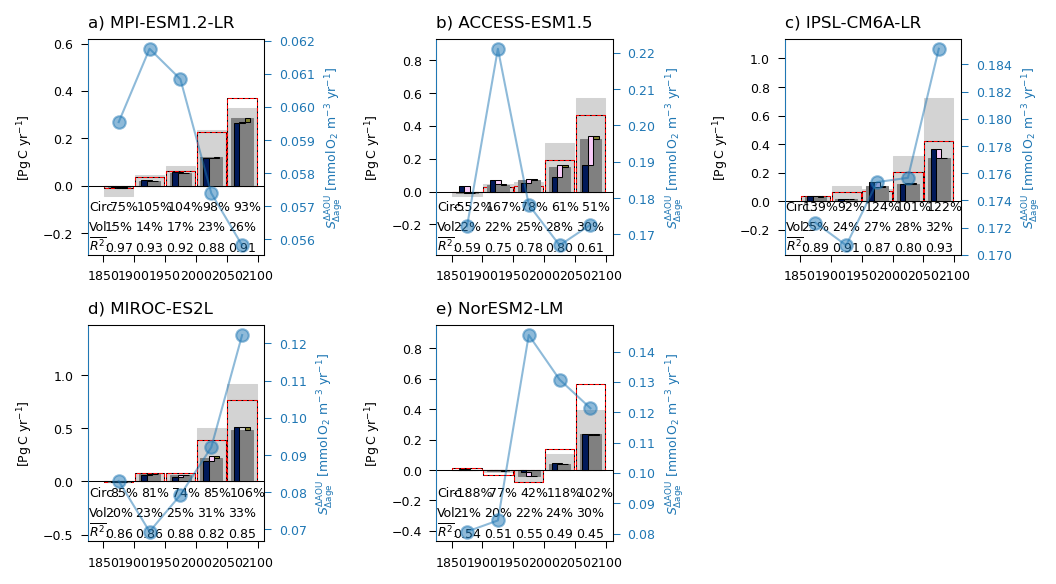

In [26]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute integrated ∆AOU = OUR * ∆Age + intercept + residual')
print('## Plot')

#____________________
# Load data2plot

savefile = dirout + 'data2plot_integrated_AOUtrend_OURxAgetrend_intercept_residual.pckl'
with open(savefile, 'rb') as file:
    data2plot = pickle.load(file)

#
# watermass='southern and atlantic significant'
watermass='southern dense significant'

#____________________
# Set figname for saving figure

figname = dirout + 'barplot_integrated_AOUtrend_OURxAgetrend_intercept_residual_'+watermass.replace(' ', '_')+'.png'

#--------------------
# Figure parameters
#--------------------

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']

zfact = 1e-18 * 117/170 * 12.01 # mmol-O -> PgC

label_dict = {
    'Global ∆AOU': r'Global $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep ∆AOU': r'Deep $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep significant ∆AOU': r'Deep significant $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆AOU'       : r'$\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆Age'       : r'$\mathrm{OUR} \times \frac{\mathrm{dAge}}{\mathrm{dt}}$',
    # 'intercept'  : r'$\mathrm{Age} \times \frac{\mathrm{dOUR}}{\mathrm{dt}}$',
    'intercept'  : r'Intercept',
    'residual'   : r'Residual'
}

color_dict = {
    'Global ∆AOU': 'lightgrey',
    '∆AOU': 'grey',
    '∆Age' : cmcrameri.cm.batlowS.colors[0],
    'intercept' : cmcrameri.cm.batlowS.colors[1],
    'residual'  : cmcrameri.cm.batlowS.colors[2]
}

kwbar = dict(linewidth=0.5, align='center')
kwbar1 = dict(linewidth=.5, align='center', edgecolor='k')

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

ncol = 3
nrow = 2
fwidth_cm = 6
fheight_cm = 5
fsize = (fwidth_cm*cm2in*ncol, fheight_cm*cm2in*nrow) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize)

#--------------------
# Plot
#--------------------

for iesm, vesm in enumerate(esm_list): 
    
    zax = ax.flat[iesm]

    #--------------------
    # 50 year periods
    #--------------------

    # Get x-ticks and xxx and www0 and www1
    x_ticks = [int(sss[:4]) for sss in data2plot[vesm]['period']]
    x_ticks.append(int(data2plot[vesm]['period'][-1][-4:])+1)
    xxx = (np.array(x_ticks[:-1])+np.array(x_ticks[1:]))/2
    
    www0 = (np.array(x_ticks[1:]) - np.array(x_ticks[:-1])) * 0.95
    www1 = (np.array(x_ticks[1:]) - np.array(x_ticks[:-1])) * 0.7
    
    
    #_________________
    # ∆AOU
    
    var = '∆AOU'
    
    hhh = np.array(data2plot[vesm][var]['total']) * zfact
    zax.bar(xxx, hhh, width=www0, label='Global ∆AOU', color=color_dict['Global '+var], edgecolor=color_dict['Global '+var], **kwbar)

    hhh = np.array(data2plot[vesm][var]['deep']) * zfact
    zax.bar(xxx, hhh, width=www0, label='Deep ∆AOU', color='none', edgecolor='k',  **kwbar)

    hhh = np.array(data2plot[vesm][var]['deep significant']) * zfact
    zax.bar(xxx, hhh, width=www0, color='none', label='Deep significant ∆AOU', linewidth=.5, ls='--', edgecolor='red', align='center')

    hhh = np.array(data2plot[vesm][var][watermass]) * zfact
    zax.bar(xxx, hhh, width=www1, label=var, color=color_dict[var], edgecolor=color_dict[var], **kwbar)

    nnn = 3
    www2=www1/(nnn+1)
    
    #_________________
    # ∆Age
    iii = 0
    var = '∆Age'
    hhh = np.array(data2plot[vesm][var][watermass]) * zfact
    bbb = 0*hhh
    xxx1 = xxx-(nnn-(1+2*iii))*www2/2
    bars = zax.bar(xxx1, hhh, width=www2, color=color_dict[var], label=var, **kwbar1)

    #_________________
    # intercept
    iii = 1
    var = 'intercept'
    bbb += hhh
    hhh = np.array(data2plot[vesm][var][watermass]) * zfact
    xxx1 = xxx-(nnn-(1+2*iii))*www2/2
    zax.bar(xxx1, hhh, bottom=bbb, width=www2, color=color_dict[var], label=var, **kwbar1)

    #_________________
    # residual
    iii = 2
    var = 'residual'
    bbb += hhh
    hhh = np.array(data2plot[vesm][var][watermass]) * zfact
    xxx1 = xxx-(nnn-(1+2*iii))*www2/2
    zax.bar(xxx1, hhh, bottom=bbb, width=www2, color=color_dict[var], label=var, **kwbar1)
    
    #_________________
    # Add OUR
    zax2  = zax.twinx()
    ccc = 'tab:blue'
    hhh = data2plot[vesm]['OUR'][watermass]
    zax2.plot(xxx, hhh, '-o', c=ccc, alpha = .5)
    zax2.set_ylabel(r'$S_{\mathrm{\Delta age}}^{\mathrm{\Delta AOU}}$'+\
                    ' [mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]', color='tab:blue')
    zax2.spines['left'].set_color(ccc)
    zax2.tick_params(axis='y', colors=ccc)
    for label in zax2.get_yticklabels(): label.set_color(ccc)
    
    #_________________
    # Decorate
    
    # if iesm==0: zax.legend()
    
    ttl = alphabet_reverse.pop()+') '+esm_name_dict[vesm]
    zax.set_title(ttl, loc='left')
    zax.set_xticks(x_ticks)
    zax.set_ylabel(r'[Pg$\,$C yr$^{-1}$]')

    ylim = zax.get_ylim()
    dylim = 0.5*(ylim[1]-ylim[0])
    ylim2 = (ylim[0]-dylim, ylim[1]+dylim)
    zax.set_ylim(ylim2)

    xlim = zax.get_xlim()
    dxlim = 0.05*(xlim[1]-xlim[0])
    xlim2 = (xlim[0]-dxlim, xlim[1])
    zax.set_xlim(xlim2)
    
    zax.axhline(0, c='k', lw=.5)

    #_________________
    # Add R2 text
    iii=0
    ytext = ylim2[0]+0.005*(ylim2[1]-ylim2[0])
    for ind, val in enumerate(data2plot[vesm]['R2'][watermass]): 
        # xtext = xxx[ind]-(nnn-(1+2*iii))*www2/2-www2/2
        # ytext = np.max([data2plot[vesm]['∆AOU'    ][watermass][ind],  data2plot[vesm]['∆Age'     ][watermass][ind], \
        #                 data2plot[vesm]['∆Age'    ][watermass][ind] + data2plot[vesm]['intercept'][watermass][ind], \
        #                 data2plot[vesm]['∆Age'    ][watermass][ind] + data2plot[vesm]['intercept'][watermass][ind] + \
        #                 data2plot[vesm]['residual'][watermass][ind], 0])
        # zax.text( xtext, ytext*zfact, f'{val:.2f}')
        xtext = xxx[ind]
        zax.text( xtext, ytext, f'{val:.2f}', ha='center', va='bottom', size=6)
    #
    xlim = zax.get_xlim()
    xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
    zax.text(xtext, ytext, r'$\overline{R^2}$:', ha='left', va='bottom', size=6)

    #_________________
    # Add volume text
    iii=0
    ytext = ylim2[0]+0.1*(ylim2[1]-ylim2[0])
    totvolume = data2plot[vesm]['volume']['total']
    for ind, val in enumerate(data2plot[vesm]['volume'][watermass]): 
        # xtext = xxx[ind]-(nnn-(1+2*iii))*www2/2-www2/2
        # ytext = np.max([data2plot[vesm]['∆AOU'    ][watermass][ind],  data2plot[vesm]['∆Age'     ][watermass][ind], \
        #                 data2plot[vesm]['∆Age'    ][watermass][ind] + data2plot[vesm]['intercept'][watermass][ind], \
        #                 data2plot[vesm]['∆Age'    ][watermass][ind] + data2plot[vesm]['intercept'][watermass][ind] + \
        #                 data2plot[vesm]['residual'][watermass][ind], 0])
        # zax.text( xtext, ytext*zfact, f'{val:.2f}')
        xtext = xxx[ind]
        zax.text( xtext, ytext, f'{val/totvolume[ind]*100:.0f}%', ha='center', va='bottom', size=6)
    #
    xlim = zax.get_xlim()
    xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
    zax.text(xtext, ytext, r'Vol.:', ha='left', va='bottom', size=6)

    #_________________
    # Add share of dAge
    iii=0
    ytext = ylim2[0]+0.195*(ylim2[1]-ylim2[0])
    daou = data2plot[vesm]['∆AOU'][watermass]
    for ind, val in enumerate(data2plot[vesm]['∆Age'][watermass]): 
        xtext = xxx1[ind]
        zax.text( xtext, ytext, f'{val/daou[ind]*100:.0f}%', ha='center', va='bottom', size=6)
    #
    xlim = zax.get_xlim()
    xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
    zax.text(xtext, ytext, r'Circ.:', ha='left', va='bottom', size=6)
#


fig.tight_layout()

#--------------------
# Decorate
#--------------------

ax.flat[-1].axis('off')


#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)


## Plot normalized by ∆AOU

2025-05-05 17:04:37.264566
# Compute ∆AOU = OUR * ∆Age + intercept + residual
## Plot normalized by ∆AOU
Save figure...
Figure saved: 25-05-05-daou-vs-dage-for-different-time-period-v2/barplot_integrated_AOUtrend_OURxAgetrend_intercept_residual_southern_and_atlantic_significant_normalized.png
peak memory: 13705.35 MiB, increment: 6828.84 MiB
CPU times: user 1.68 s, sys: 941 ms, total: 2.62 s
Wall time: 1.47 s


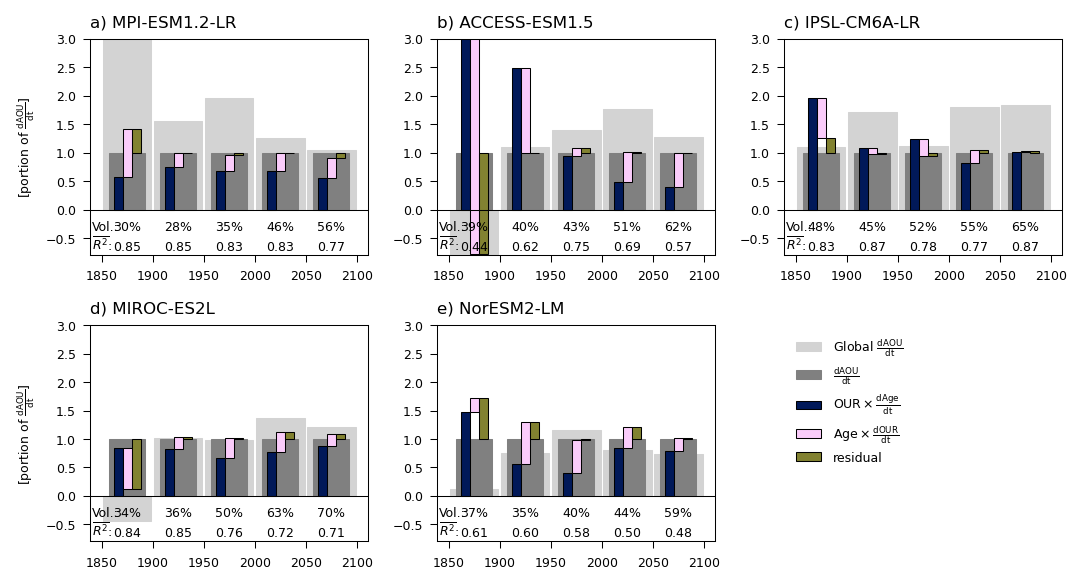

In [15]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute ∆AOU = OUR * ∆Age + intercept + residual')
print('## Plot normalized by ∆AOU')

#____________________
# Load data2plot
savefile = dirout + 'data2plot_integrated_AOUtrend_OURxAgetrend_intercept_residual.pckl'
with open(savefile, 'rb') as file:
    data2plot = pickle.load(file)

#
watermass='southern and atlantic significant'

#____________________
# Set figname for saving figure

figname = dirout + 'barplot_integrated_AOUtrend_OURxAgetrend_intercept_residual_'+watermass.replace(' ', '_')+'_normalized.png'

#--------------------
# Figure parameters
#--------------------

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']

zfact = 1e-18 * 117/170 * 12.01 # mmol-O -> PgC

label_dict = {
    'Global ∆AOU': r'Global $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep ∆AOU': r'Deep $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    'Deep significant ∆AOU': r'Deep significant $\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆AOU'       : r'$\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆Age'       : r'$\mathrm{OUR} \times \frac{\mathrm{dAge}}{\mathrm{dt}}$',
    'intercept'  : r'$\mathrm{Age} \times \frac{\mathrm{dOUR}}{\mathrm{dt}}$',
    'residual'   : r'residual'
}

color_dict = {
    'Global ∆AOU': 'lightgrey',
    '∆AOU': 'grey',
    '∆Age' : cmcrameri.cm.batlowS.colors[0],
    'intercept' : cmcrameri.cm.batlowS.colors[1],
    'residual'  : cmcrameri.cm.batlowS.colors[2]
}

kwbar = dict(linewidth=0.5, align='center')
kwbar1 = dict(linewidth=.5, align='center', edgecolor='k')

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

ncol = 3
nrow = 2
fwidth_cm = 6
fheight_cm = 5
fsize = (fwidth_cm*cm2in*ncol, fheight_cm*cm2in*nrow) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize)

#--------------------
# Plot
#--------------------

for iesm, vesm in enumerate(esm_list): 
    
    zax = ax.flat[iesm]

    #--------------------
    # 50 year periods
    #--------------------

    # Get x-ticks and xxx and www0 and www1
    x_ticks = [int(sss[:4]) for sss in data2plot[vesm]['period']]
    x_ticks.append(int(data2plot[vesm]['period'][-1][-4:])+1)
    xxx = (np.array(x_ticks[:-1])+np.array(x_ticks[1:]))/2
    
    www0 = (np.array(x_ticks[1:]) - np.array(x_ticks[:-1])) * 0.95
    www1 = (np.array(x_ticks[1:]) - np.array(x_ticks[:-1])) * 0.7
    
    norm = np.array(data2plot[vesm]['∆AOU'][watermass]) * zfact
    
    #_________________
    # ∆AOU
    
    var = '∆AOU'
    
    hhh = np.array(data2plot[vesm][var]['total']) * zfact / norm
    zax.bar(xxx, hhh, width=www0, label='Global ∆AOU', color=color_dict['Global '+var], edgecolor=color_dict['Global '+var], **kwbar)

    # hhh = np.array(data2plot[vesm][var]['deep']) * zfact
    # zax.bar(xxx, hhh, width=www0, label='Deep ∆AOU', color='none', edgecolor='k',  **kwbar)

    # hhh = np.array(data2plot[vesm][var]['deep significant']) * zfact
    # zax.bar(xxx, hhh, width=www0, color='none', label='Deep significant ∆AOU', linewidth=.5, ls='--', edgecolor='red', align='center')

    hhh = np.array(data2plot[vesm][var][watermass]) * zfact / norm
    zax.bar(xxx, hhh, width=www1, label=var, color=color_dict[var], edgecolor=color_dict[var], **kwbar)

    nnn = 3
    www2=www1/(nnn+1)
    
    #_________________
    # ∆Age
    iii = 0
    var = '∆Age'
    hhh = np.array(data2plot[vesm][var][watermass]) * zfact / norm
    bbb = 0*hhh
    xxx1 = xxx-(nnn-(1+2*iii))*www2/2
    zax.bar(xxx1, hhh, width=www2, color=color_dict[var], label=var, **kwbar1)

    #_________________
    # intercept
    iii = 1
    var = 'intercept'
    bbb += hhh
    hhh = np.array(data2plot[vesm][var][watermass]) * zfact / norm
    xxx1 = xxx-(nnn-(1+2*iii))*www2/2
    zax.bar(xxx1, hhh, bottom=bbb, width=www2, color=color_dict[var], label=var, **kwbar1)

    #_________________
    # residual
    iii = 2
    var = 'residual'
    bbb += hhh
    hhh = np.array(data2plot[vesm][var][watermass]) * zfact / norm
    xxx1 = xxx-(nnn-(1+2*iii))*www2/2
    zax.bar(xxx1, hhh, bottom=bbb, width=www2, color=color_dict[var], label=var, **kwbar1)
    
    #_________________
    # Decorate
    
    # if iesm==0: zax.legend()
    
    ttl = alphabet_reverse.pop()+') '+esm_name_dict[vesm]
    zax.set_title(ttl, loc='left')
    zax.set_xticks(x_ticks)
    # ylim = zax.get_ylim()
    # dylim = 0.1*(ylim[1]-ylim[0])
    # ylim2 = (ylim[0]-dylim, ylim[1]+dylim)
    ylim2 = (-.8, 3)
    zax.set_ylim(ylim2)
    zax.axhline(0, c='k', lw=.5)

    #_________________
    # Add R2 text
    iii=0
    for ind, val in enumerate(data2plot[vesm]['R2'][watermass]): 
        # xtext = xxx[ind]-(nnn-(1+2*iii))*www2/2-www2/2
        # ytext = np.max([data2plot[vesm][number]['∆AOU'    ][watermass][ind],  data2plot[vesm][number]['∆Age'     ][watermass][ind], \
        #                 data2plot[vesm][number]['∆Age'    ][watermass][ind] + data2plot[vesm][number]['intercept'][watermass][ind], \
        #                 data2plot[vesm][number]['∆Age'    ][watermass][ind] + data2plot[vesm][number]['intercept'][watermass][ind] + \
        #                 data2plot[vesm][number]['residual'][watermass][ind], 0])
        # zax.text( xtext, ytext*zfact, f'{val:.2f}')
        xtext = xxx[ind]
        ytext = ylim2[0]+0.01*(ylim2[1]-ylim2[0])
        zax.text( xtext, ytext, f'{val:.2f}', ha='center', va='bottom', size=6)
    #
    xlim = zax.get_xlim()
    xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
    zax.text(xtext, ytext, r'$\overline{R^2}$:', ha='left', va='bottom', size=6)

    #_________________
    # Add volume text
    iii=0
    ytext = ylim2[0]+0.1*(ylim2[1]-ylim2[0])
    totvolume = data2plot[vesm]['volume']['total']
    for ind, val in enumerate(data2plot[vesm]['volume'][watermass]): 
        # xtext = xxx[ind]-(nnn-(1+2*iii))*www2/2-www2/2
        # ytext = np.max([data2plot[vesm]['∆AOU'    ][watermass][ind],  data2plot[vesm]['∆Age'     ][watermass][ind], \
        #                 data2plot[vesm]['∆Age'    ][watermass][ind] + data2plot[vesm]['intercept'][watermass][ind], \
        #                 data2plot[vesm]['∆Age'    ][watermass][ind] + data2plot[vesm]['intercept'][watermass][ind] + \
        #                 data2plot[vesm]['residual'][watermass][ind], 0])
        # zax.text( xtext, ytext*zfact, f'{val:.2f}')
        xtext = xxx[ind]
        zax.text( xtext, ytext, f'{val/totvolume[ind]*100:.0f}%', ha='center', va='bottom', size=6)
    #
    xlim = zax.get_xlim()
    xtext = xlim[0]+0.005*(xlim[1]-xlim[0])
    zax.text(xtext, ytext, r'Vol.:', ha='left', va='bottom', size=6)
#


fig.tight_layout()

#--------------------
# Decorate
#--------------------

ax.flat[-1].axis('off')

#____________________
# legend
    # if iesm==0: zax.legend()
zax=ax.flat[0]
aaa=zax.get_legend_handles_labels()
handles = aaa[0]
labels = [label_dict[vvv] for vvv in aaa[1]]
zax = ax.flat[-1]
zax.legend(handles, labels, frameon=False, handletextpad=1, loc='upper left', bbox_to_anchor=(0, 1))

#____________________
# axis labels
for zax in ax[: , 0]: zax.set_ylabel(r'[portion of $\frac{\mathrm{dAOU}}{\mathrm{dt}}$]')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)


# Compute zonal and vertical averages ∆AOU = OUR * ∆Age + intercept + residual

## Prepare data2plot

In [16]:
%%time 
%%memit -c
# ca. 20 min
print(datetime.datetime.now())
print('# Compute zonal and vertical averages ∆AOU = OUR * ∆Age + intercept + residual')
print('## Prepare data2plot')

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']

#----------------
# Define some functions
#----------------
def compute_xavg_zavg(zwnp, zwvolume): 

    zwda = xr.DataArray(zwnp, dims=zwvolume.dims, coords=zwvolume.coords)
    zwda_zavg = compute_vertical_average(zwda)
    zwda_xavg = zonal_avg(zwda, zwvolume)
    zavg_dict = {'xxx': zwda_zavg.longitude.values, 'yyy': zwda_zavg.latitude.values, 'ccc': zwda_zavg.values}
    xavg_dict = {'xxx': zwda_xavg.latitude.values, 'yyy': zwda_xavg.depth.values, 'ccc': zwda_xavg.values}
    return xavg_dict, zavg_dict
#


#----------------
# Loop on ESM
#----------------

data2plot = {}
for iesm, vesm in enumerate(esm_list): 
    
    print('-----------------------')
    print('Prepare data for %s...'%vesm)
    print('-----------------------')

    #----------------
    # Initalize data2plot
    #----------------

    data2plot[vesm] = {
        'period':[], \
        '∆AOU xavg': {'total':[], 'deep':[], 'deep significant':[], \
                      'southern dense significant':[], 'southern light significant':[], \
                      'atlantic dense significant':[], 'atlantic light significant':[], \
                      'southern and atlantic significant': [], \
                      'southern dense':[], 'southern light':[], \
                      'atlantic dense':[], 'atlantic light':[], \
                      'southern and atlantic': []}, \
        '∆AOU zavg': {'total':[], 'deep':[], 'deep significant':[], \
                      'southern dense significant':[], 'southern light significant':[], \
                      'atlantic dense significant':[], 'atlantic light significant':[], \
                      'southern and atlantic significant': [], \
                      'southern dense':[], 'southern light':[], \
                      'atlantic dense':[], 'atlantic light':[], \
                      'southern and atlantic': []}, \
        '∆Age xavg': {'southern dense significant':[], 'southern light significant':[], \
                      'atlantic dense significant':[], 'atlantic light significant':[], \
                      'southern and atlantic significant': [], \
                      'southern dense':[], 'southern light':[], \
                      'atlantic dense':[], 'atlantic light':[], \
                      'southern and atlantic': []}, \
        '∆Age zavg': {'southern dense significant':[], 'southern light significant':[], \
                      'atlantic dense significant':[], 'atlantic light significant':[], \
                      'southern and atlantic significant': [], \
                      'southern dense':[], 'southern light':[], \
                      'atlantic dense':[], 'atlantic light':[], \
                      'southern and atlantic': []}, \
        'intercept xavg': {'southern dense significant':[], 'southern light significant':[], \
                           'atlantic dense significant':[], 'atlantic light significant':[], \
                           'southern and atlantic significant': [], \
                           'southern dense':[], 'southern light':[], \
                           'atlantic dense':[], 'atlantic light':[], \
                           'southern and atlantic': []}, \
        'intercept zavg': {'southern dense significant':[], 'southern light significant':[], \
                           'atlantic dense significant':[], 'atlantic light significant':[], \
                           'southern and atlantic significant': [], \
                           'southern dense':[], 'southern light':[], \
                           'atlantic dense':[], 'atlantic light':[], \
                           'southern and atlantic': []}, \
        'residual xavg': {'southern dense significant':[], 'southern light significant':[], \
                          'atlantic dense significant':[], 'atlantic light significant':[], \
                          'southern and atlantic significant': [], \
                          'southern dense':[], 'southern light':[], \
                          'atlantic dense':[], 'atlantic light':[], \
                          'southern and atlantic': []}, \
        'residual zavg': {'southern dense significant':[], 'southern light significant':[], \
                          'atlantic dense significant':[], 'atlantic light significant':[], \
                          'southern and atlantic significant': [], \
                          'southern dense':[], 'southern light':[], \
                          'atlantic dense':[], 'atlantic light':[], \
                          'southern and atlantic': []}
    }
    
    #----------------
    # Compute volume and omask
    #----------------
    print('   Compute volume and omask...')
    if vesm == 'NorESM2-LM': fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', diresgf='/mnt/reef-ns1002k-ns9034k/', variant='r1i1p1f1')
    else: fname_list = get_esgf_dataset_filepaths('areacello', vesm, 'historical', variant=variant_dict[vesm], 
                                                  version=version_dict['historical']['areacello'][vesm], grid=grid_dict['areacello'][vesm])
    zwds = xr.open_mfdataset(fname_list, **kwopenmfds)
    zwds2 = zwds['areacello'].to_dataset()
    zwds2 = rename_vars_dims_coords(zwds2, rename_dict)
    zwds2 = split_coords_dimensions(zwds2)
    zwds2 = shift_180_lon(zwds2)
    zarea = zwds2['areacello']
    # FOR MPI model, invert latitude dimension
    if vesm == 'MPI-ESM1-2-LR' : 
        zarea = zarea.isel(j=slice(None, None, -1))
    #

    fname = netcdfdir+vesm+'_sigma0_average_on_1950-1999.nc'
    zwds = xr.open_mfdataset(fname, **kwopenmfds)
    zwda_sigma0 = zwds['sigma0']
    if vesm == 'MPI-ESM1-2-LR' : 
        zwda_sigma0 = zwda_sigma0.isel(j=slice(None, None, -1))
    #

    depbounds, depthickness = compute_vertical_bounds_thickness(zwda_sigma0.depth)

    omask = ~(zwda_sigma0.isnull()).rename('mask').drop(['latitude', 'longitude'])
    volume = omask * depthickness * zarea

    del depbounds, depthickness
        
    #----------------
    # Loop on time period
    #----------------
        
    #----------------
    # define period_list
    nyear = 50
    yearsend   = np.arange(2099, 1850, -nyear)
    yearsstart = np.arange(2099-(nyear-1), 1850-(nyear-1), -nyear)
    period_list = []
    for yend, ystart in zip(yearsend, yearsstart): 
        period_list.append((ystart, yend))
    #
    period_list.reverse()
    
    for iperiod, vperiod in enumerate(period_list): 
        
        print(f'For period {vperiod}...')
        tperiod = f'{vperiod[0]}-{vperiod[1]}'

        data2plot[vesm]['period'].append(tperiod)
        
        #----------------
        # Load data
        #----------------
        
        print('    Load data...')
        savefile = dirout + f'{vesm}_distribution_and_linear_regression_of_aou_trend_vs_age_trend_{tperiod}.pckl'
        with open(savefile, 'rb') as file:
            data2process_significant = pickle.load(file)
        #
        
        savefile = dirout + f'{vesm}_distribution_and_linear_regression_of_aou_trend_vs_age_trend_{tperiod}_include_low_significant_trend.pckl'
        with open(savefile, 'rb') as file:
            data2process_with_low_significant = pickle.load(file)
        #
        
        #----------------
        # Loop on water-masses
        #----------------
        
        for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 

            #________________
            # Significant water-masses
            
            zw_pred_3D = data2process_significant[watermass]['predicted aou']['3D']['ccc']
            zw_bias_3D = data2process_significant[watermass]['aou prediction bias']['3D']['ccc']
            zw_itcpt   = data2process_significant[watermass]['linregress']['intercept']

            xavg, zavg = compute_xavg_zavg(zw_pred_3D + zw_bias_3D, volume)            
            data2plot[vesm]['∆AOU zavg'][watermass+' significant'].append(zavg)
            data2plot[vesm]['∆AOU xavg'][watermass+' significant'].append(xavg)

            xavg, zavg = compute_xavg_zavg(zw_pred_3D - zw_itcpt, volume)
            data2plot[vesm]['∆Age zavg'][watermass+' significant'].append(zavg)
            data2plot[vesm]['∆Age xavg'][watermass+' significant'].append(xavg)
            
            xavg, zavg = compute_xavg_zavg(zw_pred_3D*0 + zw_itcpt, volume)
            data2plot[vesm]['intercept zavg'][watermass+' significant'].append(zavg)
            data2plot[vesm]['intercept xavg'][watermass+' significant'].append(xavg)

            xavg, zavg = compute_xavg_zavg(zw_bias_3D, volume)
            data2plot[vesm]['residual zavg'][watermass+' significant'].append(zavg)
            data2plot[vesm]['residual xavg'][watermass+' significant'].append(xavg)
            
           #________________
            # Including low significant water-masses
            
            zw_pred_3D = data2process_with_low_significant[watermass]['predicted aou']['3D']['ccc']
            zw_bias_3D = data2process_with_low_significant[watermass]['aou prediction bias']['3D']['ccc']
            zw_itcpt   = data2process_with_low_significant[watermass]['linregress']['intercept']
            
            xavg, zavg = compute_xavg_zavg(zw_pred_3D + zw_bias_3D, volume)
            data2plot[vesm]['∆AOU zavg'][watermass].append(zavg)
            data2plot[vesm]['∆AOU xavg'][watermass].append(xavg)

            xavg, zavg = compute_xavg_zavg(zw_pred_3D - zw_itcpt, volume)
            data2plot[vesm]['∆Age zavg'][watermass].append(zavg)
            data2plot[vesm]['∆Age xavg'][watermass].append(xavg)
            
            xavg, zavg = compute_xavg_zavg(zw_pred_3D*0 + zw_itcpt, volume)
            data2plot[vesm]['intercept zavg'][watermass].append(zavg)
            data2plot[vesm]['intercept xavg'][watermass].append(xavg)

            xavg, zavg = compute_xavg_zavg(zw_bias_3D, volume)
            data2plot[vesm]['residual zavg'][watermass].append(zavg)
            data2plot[vesm]['residual xavg'][watermass].append(xavg)
        #
        
        #----------------
        # Southern and atlantic significant
        #----------------
        
        zw_pred_3D_SA, zw_bias_3D_SA, zw_itcpt_3D_SA = [], [], []
        for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 

            zw_pred_3D = data2process_significant[watermass]['predicted aou']['3D']['ccc']
            zw_bias_3D = data2process_significant[watermass]['aou prediction bias']['3D']['ccc']
            zw_itcpt   = data2process_significant[watermass]['linregress']['intercept']
            
            zw_pred_3D_SA .append(zw_pred_3D)
            zw_bias_3D_SA .append(zw_bias_3D)
            zw_itcpt_3D = np.where(np.isnan(zw_pred_3D), np.nan, zw_itcpt)
            zw_itcpt_3D_SA.append(zw_itcpt_3D)

        #
        
        zw_pred_3D_SA  = np.array(zw_pred_3D_SA)
        zw_bias_3D_SA  = np.array(zw_bias_3D_SA)
        zw_itcpt_3D_SA = np.array(zw_itcpt_3D_SA)

        all_nan_mask = np.all(np.isnan(zw_pred_3D_SA), axis=0)
        zwnansum = np.nansum(zw_pred_3D_SA, axis=0)
        zw_pred_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

        all_nan_mask = np.all(np.isnan(zw_bias_3D_SA), axis=0)
        zwnansum = np.nansum(zw_bias_3D_SA, axis=0)
        zw_bias_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)
        
        all_nan_mask = np.all(np.isnan(zw_itcpt_3D_SA), axis=0)
        zwnansum = np.nansum(zw_itcpt_3D_SA, axis=0)
        zw_itcpt_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

        watermass = 'southern and atlantic significant'
        xavg, zavg = compute_xavg_zavg(zw_pred_3D_SA + zw_bias_3D_SA, volume)
        data2plot[vesm]['∆AOU zavg'][watermass].append(zavg)
        data2plot[vesm]['∆AOU xavg'][watermass].append(xavg)

        xavg, zavg = compute_xavg_zavg(zw_pred_3D_SA - zw_itcpt_3D_SA, volume)
        data2plot[vesm]['∆Age zavg'][watermass].append(zavg)
        data2plot[vesm]['∆Age xavg'][watermass].append(xavg)

        xavg, zavg = compute_xavg_zavg(zw_pred_3D_SA*0 + zw_itcpt_3D_SA, volume)
        data2plot[vesm]['intercept zavg'][watermass].append(zavg)
        data2plot[vesm]['intercept xavg'][watermass].append(xavg)

        xavg, zavg = compute_xavg_zavg(zw_bias_3D_SA, volume)
        data2plot[vesm]['residual zavg'][watermass].append(zavg)
        data2plot[vesm]['residual xavg'][watermass].append(xavg)
        
        #----------------
        # Southern and atlantic including low significant water-masses
        #----------------
        
        zw_pred_3D_SA, zw_bias_3D_SA, zw_itcpt_3D_SA = [], [], []
        for watermass in ['southern dense', 'southern light', 'atlantic dense', 'atlantic light']: 

            zw_pred_3D = data2process_with_low_significant[watermass]['predicted aou']['3D']['ccc']
            zw_bias_3D = data2process_with_low_significant[watermass]['aou prediction bias']['3D']['ccc']
            zw_itcpt   = data2process_with_low_significant[watermass]['linregress']['intercept']
            
            zw_pred_3D_SA .append(zw_pred_3D)
            zw_bias_3D_SA .append(zw_bias_3D)
            zw_itcpt_3D = np.where(np.isnan(zw_pred_3D), np.nan, zw_itcpt)
            zw_itcpt_3D_SA.append(zw_itcpt_3D)

        #

        zw_pred_3D_SA  = np.array(zw_pred_3D_SA)
        zw_bias_3D_SA  = np.array(zw_bias_3D_SA)
        zw_itcpt_3D_SA = np.array(zw_itcpt_3D_SA)

        all_nan_mask = np.all(np.isnan(zw_pred_3D_SA), axis=0)
        zwnansum = np.nansum(zw_pred_3D_SA, axis=0)
        zw_pred_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

        all_nan_mask = np.all(np.isnan(zw_bias_3D_SA), axis=0)
        zwnansum = np.nansum(zw_bias_3D_SA, axis=0)
        zw_bias_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)
        
        all_nan_mask = np.all(np.isnan(zw_itcpt_3D_SA), axis=0)
        zwnansum = np.nansum(zw_itcpt_3D_SA, axis=0)
        zw_itcpt_3D_SA = np.where(all_nan_mask, np.nan, zwnansum)

        watermass = 'southern and atlantic'
        xavg, zavg = compute_xavg_zavg(zw_pred_3D_SA + zw_bias_3D_SA, volume)
        data2plot[vesm]['∆AOU zavg'][watermass].append(zavg)
        data2plot[vesm]['∆AOU xavg'][watermass].append(xavg)

        xavg, zavg = compute_xavg_zavg(zw_pred_3D_SA - zw_itcpt_3D_SA, volume)
        data2plot[vesm]['∆Age zavg'][watermass].append(zavg)
        data2plot[vesm]['∆Age xavg'][watermass].append(xavg)

        xavg, zavg = compute_xavg_zavg(zw_pred_3D_SA*0 + zw_itcpt_3D_SA, volume)
        data2plot[vesm]['intercept zavg'][watermass].append(zavg)
        data2plot[vesm]['intercept xavg'][watermass].append(xavg)

        xavg, zavg = compute_xavg_zavg(zw_bias_3D_SA, volume)
        data2plot[vesm]['residual zavg'][watermass].append(zavg)
        data2plot[vesm]['residual xavg'][watermass].append(xavg)

        #----------------
        # Total, deep and deep significant (only ∆AOU)
        #----------------

        watermass = 'total'
        zw_pred_3D = data2process_significant[watermass]['predicted aou']['3D']['ccc']
        zw_bias_3D = data2process_significant[watermass]['aou prediction bias']['3D']['ccc']
        xavg, zavg = compute_xavg_zavg(zw_pred_3D + zw_bias_3D, volume)
        data2plot[vesm]['∆AOU zavg'][watermass].append(zavg)
        data2plot[vesm]['∆AOU xavg'][watermass].append(xavg)
        
        watermass = 'deep'
        zw_pred_3D = data2process_significant[watermass]['predicted aou']['3D']['ccc']
        zw_bias_3D = data2process_significant[watermass]['aou prediction bias']['3D']['ccc']
        xavg, zavg = compute_xavg_zavg(zw_pred_3D + zw_bias_3D, volume)
        data2plot[vesm]['∆AOU zavg'][watermass].append(zavg)
        data2plot[vesm]['∆AOU xavg'][watermass].append(xavg)
        
        watermass = 'deep'
        zw_pred_3D = data2process_significant[watermass]['predicted aou']['3D']['ccc']
        zw_bias_3D = data2process_significant[watermass]['aou prediction bias']['3D']['ccc']
        xavg, zavg = compute_xavg_zavg(zw_pred_3D + zw_bias_3D, volume)
        data2plot[vesm]['∆AOU zavg'][watermass].append(zavg)
        data2plot[vesm]['∆AOU xavg'][watermass].append(xavg)
    #
#

#----------------
# Save data2plot in pickle
#----------------

savefile = dirout + 'data2plot_zonal_vertical_averages_AOUtrend_OURxAgetrend_intercept_residual.pckl'
with open(savefile, "wb") as file:
    pickle.dump(data2plot, file)
#



2025-05-05 17:04:45.434507
# Compute zonal and vertical averages ∆AOU = OUR * ∆Age + intercept + residual
## Prepare data2plot
-----------------------
Prepare data for MPI-ESM1-2-LR...
-----------------------
   Compute volume and omask...
For period (1850, 1899)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1900, 1949)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1950, 1999)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2000, 2049)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2050, 2099)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

-----------------------
Prepare data for ACCESS-ESM1-5...
-----------------------
   Compute volume and omask...
For period (1850, 1899)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1900, 1949)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1950, 1999)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2000, 2049)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2050, 2099)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

-----------------------
Prepare data for IPSL-CM6A-LR...
-----------------------
   Compute volume and omask...
For period (1850, 1899)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1900, 1949)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1950, 1999)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2000, 2049)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2050, 2099)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

-----------------------
Prepare data for MIROC-ES2L...
-----------------------
   Compute volume and omask...
For period (1850, 1899)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1900, 1949)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1950, 1999)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2000, 2049)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2050, 2099)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

-----------------------
Prepare data for NorESM2-LM...
-----------------------
   Compute volume and omask...
For period (1850, 1899)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1900, 1949)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (1950, 1999)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2000, 2049)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

For period (2050, 2099)...
    Load data...


/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(

peak memory: 19059.04 MiB, increment: 12177.89 MiB
CPU times: user 11min 2s, sys: 4min 28s, total: 15min 31s
Wall time: 25min 4s


## Plot section

2025-05-05 18:01:37.010579
# Compute zonal and vertical averages ∆AOU = OUR * ∆Age + intercept + residual
## Plot section


NameError: name 'kwpcm' is not defined

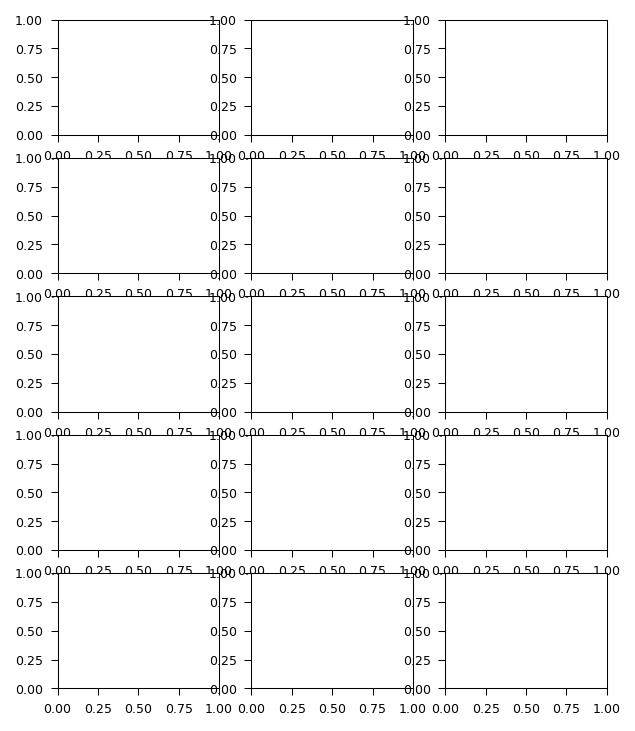

In [17]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute zonal and vertical averages ∆AOU = OUR * ∆Age + intercept + residual')
print('## Plot section')

#____________________
# Load data2plot

savefile = dirout + 'data2plot_zonal_vertical_averages_AOUtrend_OURxAgetrend_intercept_residual.pckl'
with open(savefile, 'rb') as file:
    data2plot = pickle.load(file)
#
# data2plot[vesm][var][watermass] = list of {'xxx': np.array, 'yyy': np.array, 'ccc': np.array}
watermass='southern and atlantic significant' 
# 'total', 'deep', 'deep significant',
# 'southern dense significant', 'southern light significant', 
# 'atlantic dense significant', 'atlantic light significant',
# 'southern and atlantic significant'
# 'southern dense', 'southern light'
# 'atlantic dense', 'atlantic light'
# 'southern and atlantic'
var = '∆AOU xavg'
# '∆AOU xavg', '∆AOU zavg', 
# '∆Age xavg', '∆Age zavg',
# 'intercept xavg', 'intercept zavg',
# 'residual xavg', 'residual zavg'


#____________________
# Set figname for saving figure

if var.split(' ')[-1] == 'xavg' : figname_prefix = 'section_zonal_average'
else: sys.exit('!!!ERROR: can only plot section')
if var.split(' ')[0] == '∆AOU' : figname_suffix = 'delta_aou'
elif var.split(' ')[0] == '∆Age' : figname_suffix = 'delta_age'
elif var.split(' ')[0] == 'intercept' : figname_suffix = 'intercept'
elif var.split(' ')[0] == 'residual' : figname_suffix = 'residual'
else: figname_suffix = ''
figname = dirout + figname_prefix+'_OURxAgetrend_intercept_residual_'+watermass.replace(' ', '_')+'_'+figname_suffix+'.png'

#--------------------
# Figure parameters
#--------------------

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
period_idx = [2, 3, 4]

zfact = 1

#______________
# colorbar label
clabel_dict = {
    '∆AOU'       : r'$\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆Age'       : r'$\mathrm{OUR} \times \frac{\mathrm{dAge}}{\mathrm{dt}}$',
    'intercept'  : r'Intercept',
    'residual'   : r'Residual'
}

#______________
# axis labeling and limits
if var.split(' ')[-1] == 'xavg' : 
    xlabel = 'Latitude [Deg. N]'
    ylabel = 'Depth [m]'
    xlim = (-90, 90)
    ylim = (6000, -10)
elif var.split(' ')[-1] == 'zavg' : 
    xlabel = 'Longitude [Deg. E]'
    ylabel = 'Latitude [Deg. N]'
    xlim = (None, None)
    ylim = (None, None)
else: 
    xlabel = ''
    ylabel = ''
    xlim = (None, None)
    ylim = (None, None)
#        

#______________
# cmap
a = cmcrameri.cm.vik
colors = a(np.linspace(0,1,10+2))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])
newcmap.set_bad("none")

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

#______________
# Set figure
ncol = len(period_idx)
nrow = len(esm_list)
fwidth_cm = 4
fheight_cm = 3
fsize = (fwidth_cm*cm2in*ncol, fheight_cm*cm2in*nrow) # width, height
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize)

#--------------------
# Plot
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    
    for iperiod, vperiod in enumerate(period_idx): 
        
        zwdata = data2plot[vesm][var][watermass][vperiod]

        zax = ax[iesm, iperiod]
        xxx = data2plot[vesm][var][watermass][vperiod]['xxx']
        yyy = data2plot[vesm][var][watermass][vperiod]['yyy']
        ccc = data2plot[vesm][var][watermass][vperiod]['ccc']
        ccc = np.where(ccc!=0, ccc, np.nan)
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        pcm[iesm, iperiod] = zwpcm
        zax.set_ylim(ylim)
        zax.set_xlim(xlim)

        zwtxt = extended_alphabet_reverse.pop() + f') '
        zax.text(.02, .98, zwtxt, transform=zax.transAxes, ha='left', va='top')
        
    #
#


#--------------------
# Decorate
#--------------------

fig.tight_layout()

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.2, 1.2, vesm, transform=zax.transAxes, ha='right', va='top', rotation=30.)
#

for zax in ax[:, 0]: zax.set_ylabel(ylabel)
for zax in ax[-1, :]: zax.set_xlabel(xlabel)
        
for iperiod, vperiod in enumerate(period_idx): 
    zax = ax[0, iperiod]
    zax.text(.5, 1.3, data2plot[esm_list[0]]['period'][vperiod], transform=zax.transAxes, ha='center', va='bottom')
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, -1].get_position()
zw2 = ax[1, -1].get_position()
nx0 = zw1.x1 + .2*zw1.height
ny0 = zw2.y0
nh  = zw1.y1 - ny0
nw  = 0.08*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='vertical', \
                    ticklocation='right', extend='both')
clabel = clabel_dict[var.split(' ')[0]] + '   [mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]'
cbar.set_label(clabel)

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)



## Plot map

2025-05-05 18:01:41.738838
# Compute zonal and vertical averages ∆AOU = OUR * ∆Age + intercept + residual
## Plot map
Save figure...
Figure saved: 25-05-05-daou-vs-dage-for-different-time-period-v2/map_vertical_average_OURxAgetrend_intercept_residual_southern_and_atlantic_significant_delta_aou.png
peak memory: 24576.48 MiB, increment: 13301.04 MiB
CPU times: user 55.3 s, sys: 5.24 s, total: 1min
Wall time: 55.5 s


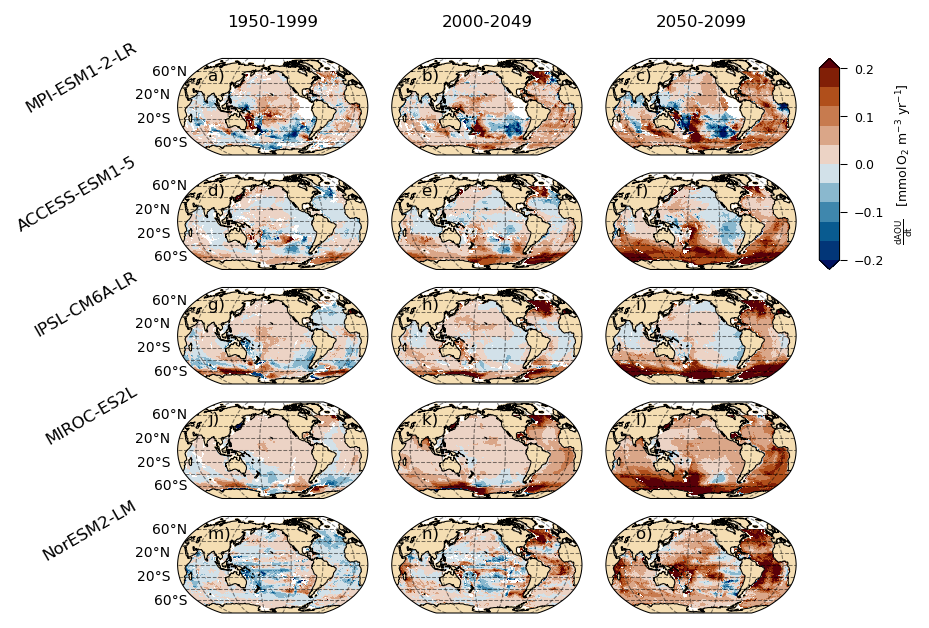

In [18]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Compute zonal and vertical averages ∆AOU = OUR * ∆Age + intercept + residual')
print('## Plot map')

#____________________
# Load data2plot

savefile = dirout + 'data2plot_zonal_vertical_averages_AOUtrend_OURxAgetrend_intercept_residual.pckl'
with open(savefile, 'rb') as file:
    data2plot = pickle.load(file)
#
# data2plot[vesm][var][watermass] = list of {'xxx': np.array, 'yyy': np.array, 'ccc': np.array}
watermass='southern and atlantic significant' 
# 'total', 'deep', 'deep significant',
# 'southern dense significant', 'southern light significant', 
# 'atlantic dense significant', 'atlantic light significant',
# 'southern and atlantic significant'
# 'southern dense', 'southern light'
# 'atlantic dense', 'atlantic light'
# 'southern and atlantic'
var = '∆AOU zavg'
# '∆AOU xavg', '∆AOU zavg', 
# '∆Age xavg', '∆Age zavg',
# 'intercept xavg', 'intercept zavg',
# 'residual xavg', 'residual zavg'

#____________________
# Set figname for saving figure

if var.split(' ')[-1] == 'zavg' : figname_prefix = 'map_vertical_average'
else: sys.exit('!!! ERROR can only plot map')
if var.split(' ')[0] == '∆AOU' : figname_suffix = 'delta_aou'
elif var.split(' ')[0] == '∆Age' : figname_suffix = 'delta_age'
elif var.split(' ')[0] == 'intercept' : figname_suffix = 'intercept'
elif var.split(' ')[0] == 'residual' : figname_suffix = 'residual'
else: figname_suffix = ''
figname = dirout + figname_prefix+'_OURxAgetrend_intercept_residual_'+watermass.replace(' ', '_')+'_'+figname_suffix+'.png'

#--------------------
# Figure parameters
#--------------------

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
period_idx = [2, 3, 4]

zfact = 1

#______________
# colorbar label
clabel_dict = {
    '∆AOU'       : r'$\frac{\mathrm{dAOU}}{\mathrm{dt}}$',
    '∆Age'       : r'$\mathrm{OUR} \times \frac{\mathrm{dAge}}{\mathrm{dt}}$',
    'intercept'  : r'Intercept',
    'residual'   : r'Residual'
}

#______________
# axis labeling and limits
if var.split(' ')[-1] == 'xavg' : 
    xlabel = 'Latitude [Deg. N]'
    ylabel = 'Depth [m]'
    xlim = (-90, 90)
    ylim = (6000, -10)
elif var.split(' ')[-1] == 'zavg' : 
    xlabel = 'Longitude [Deg. E]'
    ylabel = 'Latitude [Deg. N]'
    xlim = (None, None)
    ylim = (None, None)
else: 
    xlabel = ''
    ylabel = ''
    xlim = (None, None)
    ylim = (None, None)
#        

#______________
# cmap
a = cmcrameri.cm.vik
colors = a(np.linspace(0,1,10+2))
newcmap = ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])
newcmap.set_bad("none")

#______________
# pcm keywords
kwpcm = dict(cmap=newcmap, vmin=-.2, vmax=.2, transform=ccrs.PlateCarree())

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

#______________
# Set figure
ncol = len(period_idx)
nrow = len(esm_list)
fwidth_cm = 4
fheight_cm = 2
fsize = (fwidth_cm*cm2in*ncol, fheight_cm*cm2in*nrow) # width, height
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, squeeze=False, \
                       subplot_kw=dict(projection=ccrsproj))

#--------------------
# Plot
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    
    for iperiod, vperiod in enumerate(period_idx): 
        
        zwdata = data2plot[vesm][var][watermass][vperiod]

        zax = ax[iesm, iperiod]
        xxx = data2plot[vesm][var][watermass][vperiod]['xxx']
        yyy = data2plot[vesm][var][watermass][vperiod]['yyy']
        ccc = data2plot[vesm][var][watermass][vperiod]['ccc']
        ccc = np.where(ccc!=0, ccc, np.nan)
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        pcm[iesm, iperiod] = zwpcm
        zax.set_ylim(ylim)
        zax.set_xlim(xlim)

        zax.set_global()

        if iperiod==0: 
            add_gridlines_coastline_and_land(zax)
        else: 
            add_gridlines_coastline_and_land(zax, noticklabels=True)
        #
        
        zwtxt = extended_alphabet_reverse.pop() + f') '
        zax.text(.16, .9, zwtxt, transform=zax.transAxes, ha='left', va='top')
        
    #
#


#--------------------
# Decorate
#--------------------

fig.tight_layout()

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.2, 1.2, vesm, transform=zax.transAxes, ha='right', va='top', rotation=30.)
#

for zax in ax[:, 0]: zax.set_ylabel(ylabel)
for zax in ax[-1, :]: zax.set_xlabel(xlabel)
        
for iperiod, vperiod in enumerate(period_idx): 
    zax = ax[0, iperiod]
    zax.text(.5, 1.3, data2plot[esm_list[0]]['period'][vperiod], transform=zax.transAxes, ha='center', va='bottom')
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, -1].get_position()
zw2 = ax[1, -1].get_position()
nx0 = zw1.x1 + .2*zw1.height
ny0 = zw2.y0
nh  = zw1.y1 - ny0
nw  = 0.08*nh
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='vertical', \
                    ticklocation='right', extend='both')
clabel = clabel_dict[var.split(' ')[0]] + '   [mmol$\,$O$_2$ m$^{-3}$ yr$^{-1}$]'
cbar.set_label(clabel)

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)



# Plot water-masses mask

2025-05-05 18:11:30.162114
# Plot water-masses mask


<string>:91: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


Save figure...
Figure saved: 25-05-05-daou-vs-dage-for-different-time-period-v2/section_water_mass_distribution_zonal_average_2050-2099_include_low_significant_trend.png
peak memory: 28690.97 MiB, increment: 14292.94 MiB
CPU times: user 4.48 s, sys: 9.26 s, total: 13.7 s
Wall time: 19.4 s


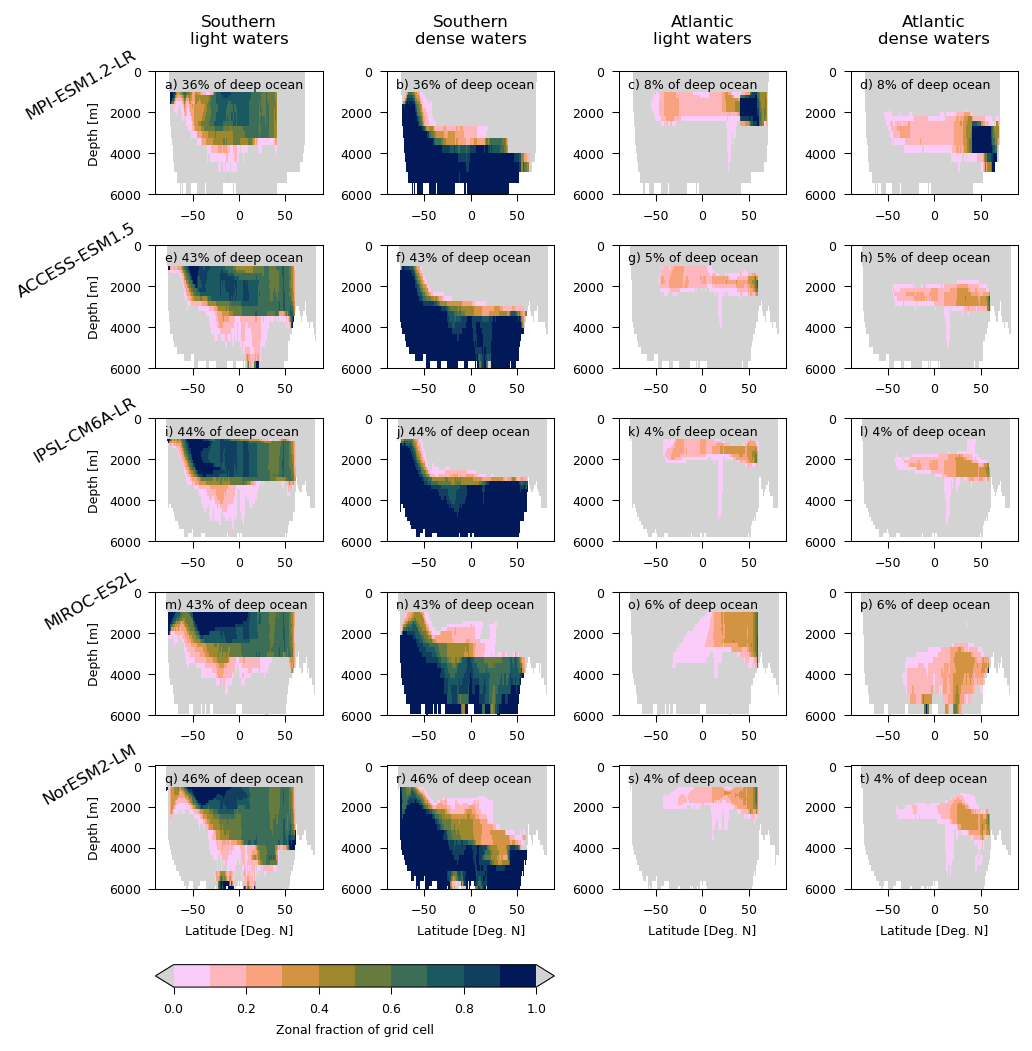

In [20]:
%%time
%%memit -c
print(datetime.datetime.now())
print('# Plot water-masses mask')

# tperiod = '1950-1999'
tperiod = '2050-2099'


figname = dirout+f'section_water_mass_distribution_zonal_average_{tperiod}_include_low_significant_trend.png'

#--------------------
# Figure parameters
#--------------------

esm_list = ['MPI-ESM1-2-LR', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'NorESM2-LM']
region_list = ['southern light', 'southern dense', 'atlantic light', 'atlantic dense']

#______________
# Figure size
nrow, ncol = len(esm_list), len(region_list)
fwidth_cm, fheight_cm = 4*ncol, 3*nrow
fsize = (fwidth_cm*cm2in, fheight_cm*cm2in) # width, height

#______________
# cmap
a = cmcrameri.cm.batlow_r
colors = a(np.linspace(0,1,10))
newcmap = ListedColormap(colors[:])
newcmap.set_over('lightgrey')
newcmap.set_under('lightgrey')
newcmap.set_bad("none")

#______________
# pcm keywords
kwpcm = dict(cmap=newcmap, vmin=0, vmax=1)

#______________
# panel labeling
import string
alphabet = list(string.ascii_lowercase)
alphabet_reverse = alphabet[::-1]
# Create a list of double letter combinations (aa, ab, ..., zz)
double_letters = [a + b for a in string.ascii_lowercase for b in string.ascii_lowercase]
extended_alphabet = alphabet + double_letters
extended_alphabet_reverse = extended_alphabet[::-1]

region_label_dict = {
    'total': 'Total ocean', 
    'deep' : 'Deep ocean', 
    'deep significant' : 'Deep ocean\nsignificant', 
    'southern'  : 'Southern waters',  
    'southern dense': 'Southern\ndense waters', 
    'southern light': 'Southern\nlight waters', 
    'atlantic': 'Atlantic waters',
    'atlantic dense': 'Atlantic\ndense waters', 
    'atlantic light': 'Atlantic\nlight waters', 
    'southern and atlantic': 'Southern and\nAtlantic waters',
    'reminder deep and significant': 'Rest of deep\nocean significant', 
    'deep and non significant': 'Deep ocean\nnon-significant', 
    'surface': 'Upper ocean'
}

#______________
# Create figure and axes
fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=fsize, squeeze=False)


#--------------------
# Plot
#--------------------

pcm = np.zeros_like(ax)
for iesm, vesm in enumerate(esm_list): 
    
    #____________________
    # Load data2plot
    savefile = dirout + f'{vesm}_distribution_and_linear_regression_of_aou_trend_vs_age_trend_{tperiod}_water_types_adapated_to_time_periods_include_low_significant_trend.pckl'
    # Open the pickle file in binary read mode
    with open(savefile, 'rb') as file:
        # Load the dictionary from the pickle file
        data2plot = pickle.load(file)
    #

    for iregion, vregion in enumerate(region_list): 

        zax = ax[iesm, iregion]
        xxx = data2plot[vregion]['water mass distribution']['zonal average']['xxx']
        yyy = data2plot[vregion]['water mass distribution']['zonal average']['yyy']
        ccc = data2plot[vregion]['water mass distribution']['zonal average']['ccc']
        ccc = np.where(ccc>1, 1, ccc) # small fix for some values that are above 1
        ccc = np.where(ccc==0, -1, ccc) # small fix for having values equal to zero set negative for visualisation
        zwpcm = zax.pcolormesh(xxx, yyy, ccc, **kwpcm)
        pcm[iesm, iregion] = zwpcm
        zax.set_ylim((6000, -10))
        zax.set_xlim((-90, 90))

        # ocean_frac = data2plot[vregion]['volume']/data2plot['total']['volume']*100
        # ttl = extended_alphabet_reverse.pop() + f') {ocean_frac:.0f}% of ocean'
        # zax.text(-80, 800, ttl)
        ocean_frac = data2plot[vregion]['volume']/data2plot['deep']['volume']*100
        ttl = extended_alphabet_reverse.pop() + f') {ocean_frac:.0f}% of deep ocean'
        zax.text(-80, 800, ttl, fontsize=6)
        # zax.set_title(ttl, loc='left')
    
    #
#

fig.tight_layout()

#--------------------
# Decorate
#--------------------

for iesm, vesm in enumerate(esm_list) : 
    zax = ax[iesm, 0]
    zax.text(-.1, 1.2, esm_name_dict[vesm], transform=zax.transAxes, ha='right', va='top', rotation=30.)
#
for iregion, vregion in enumerate(region_list) : 
    zax = ax[0, iregion]
    zax.text(.5, 1.2, region_label_dict[vregion], transform=zax.transAxes, ha='center', va='bottom')
#
        
for zax in ax[:, 0]: zax.set_ylabel('Depth [m]')
for zax in ax[-1, :]: zax.set_xlabel('Latitude [Deg. N]')

#---------------------
# Colorbar
#---------------------

zw1 = ax[-1, 0].get_position()
zw2 = ax[-1, 1].get_position()
nx0 = zw1.x0
ny0 = zw1.y0 - .8*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.06*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm.flat[0], cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='both')
cbar.set_label(r'Zonal fraction of grid cell')

#--------------------
# Save figure
#--------------------

print('Save figure...')
fig.savefig(figname, bbox_inches='tight')
print('Figure saved: '+figname)

